## Imports 

In [19]:
# Imports
import time
import random
import ast
import numpy as np
from numpy import nan
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Video, HTML
import os
import scipy.stats as stats
from scipy.special import softmax
from functools import partial
from scipy.optimize import Bounds, minimize
import itertools
from tqdm.auto import tqdm 
import pickle
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import multiprocess as mp
import warnings
from models import TI_RL
from model_init import *
import plotter
from helpers import *
import importlib
from groupBMC.groupBMC import GroupBMC
from sklearn.linear_model import LinearRegression, HuberRegressor
import pingouin as pg
# warnings.filterwarnings('default')

# Cleaning

In [20]:
## loop through files
os.chdir('../data/raw_data')
cwd = os.getcwd()
all_data = []
participants = []
for file in os.listdir(cwd):
    if file.endswith('.csv'):
        data = pd.read_csv(file)
        participants.append(data['Participant'].unique()[0])

        #keep only rows of actual trials
        data = data.dropna(axis=0,subset=['Trial'])
        data.reset_index(inplace=True)
        all_data.append(data)
all_data = pd.concat(all_data)

## load post-task data 
post_data = pd.read_csv('../post_task_data')


### clean up the dataframe

## rename columns
all_data = all_data.rename(columns={'Accuracy': 'Accuracy human', 'key_resp.rt': 'RT', 'Chosen_rank': 'Chosen_Rank','Chosen_item': 'Chosen_Item', 'Loser': 'Losing_Item', 'Winner': 'Winning_Item'})


## revert the winners/losers, ranks etc. on trials that come *after* the switch block, but before the switch could have possibly been detected (i.e. trials in block 4 before P has been told that 7<1)
switch_block = 4
all_data.loc[(all_data['Switched'] == 0) & (all_data['Block']<= switch_block), 'Winning_Item'] = all_data.loc[(all_data['Switched'] == 0) & (all_data['Block']<= switch_block), ['Item_1', 'Item_2']].max(axis=1).to_numpy()
all_data.loc[(all_data['Switched'] == 0) & (all_data['Block']<= switch_block), 'Losing_Item'] = all_data.loc[(all_data['Switched'] == 0) & (all_data['Block']<= switch_block), ['Item_1', 'Item_2']].min(axis=1).to_numpy()
all_data.loc[(all_data['Switched'] == 0) & (all_data['Block']<= switch_block), 'Rank_1'] = all_data.loc[(all_data['Switched'] == 0) & (all_data['Block']<= switch_block), 'Item_1'].to_numpy()
all_data.loc[(all_data['Switched'] == 0) & (all_data['Block']<= switch_block), 'Rank_2'] = all_data.loc[(all_data['Switched'] == 0) & (all_data['Block']<= switch_block), 'Item_2'].to_numpy()
# all_data.loc[(all_data['Switched'] == 0) & (all_data['Block']<= switch_block), 'Rank_distance'] = np.abs(all_data.loc[(all_data['Switched'] == 0) & (all_data['Block']<= switch_block), ['Item_1','Item_2']].diff(axis=1).iloc[:,1].to_numpy())

## rename switches
all_data.loc[all_data['Switched']==0, 'Switched'] = 'pre'
all_data.loc[all_data['Switched']==1, 'Switched'] = 'post'

## distances
all_data['Item_distance'] = np.abs(all_data['Item_1'] - all_data['Item_2'])
all_data['Rank_distance'] = np.abs(all_data['Rank_1'] - all_data['Rank_2'])

## winning/losing ranks
all_data['Losing_Rank'] = all_data[['Rank_1','Rank_2']].min(axis=1)
all_data['Winning_Rank'] = all_data[['Rank_1','Rank_2']].max(axis=1)

## create a new column containing whichever of item_1 or item_2 is not the 'Chosen_Item'
all_data['Unchosen_Item'] = all_data['Item_1'].where(all_data['Item_1'] != all_data['Chosen_Item'], all_data['Item_2'])

## fix pair values
all_data = pair_value(all_data, 'Item')

## add column containing comparison as string
combined = np.sort(all_data[['Item_1','Item_2']]).astype(int).astype(int)
comb = ['{}<{}'.format(c[0],c[1]) for c in combined]
all_data['Comparison'] = comb
    
## revert chdir back to main analysis folder
os.chdir('../../analysis')


all_data.tail(20)



,index,Unnamed: 0,Participant,Trial,Block,Item_1,Item_2,Rank_1,Rank_2,Image_1,...,final_loc_item_06_slipper.jpg,final_loc_item_07_phone.jpg,mouse_select.clicked_name,Direction,Item_distance,Rank_distance,Losing_Rank,Winning_Rank,Unchosen_Item,Comparison
304,357,357,226,305.0,6.0,4.0,5.0,3.0,4.0,01_scarf.jpg,...,NaN,NaN,NaN,up,1.0,1.0,3.0,4.0,5.0,4<5
305,358,358,226,306.0,6.0,2.0,7.0,1.0,6.0,04_satellite_dish.jpg,...,NaN,NaN,NaN,up,5.0,5.0,1.0,6.0,7.0,2<7
306,359,359,226,307.0,6.0,2.0,3.0,1.0,2.0,04_satellite_dish.jpg,...,NaN,NaN,NaN,up,1.0,1.0,1.0,2.0,2.0,2<3
307,360,360,226,308.0,6.0,5.0,6.0,4.0,5.0,03_dress.jpg,...,NaN,NaN,NaN,up,1.0,1.0,4.0,5.0,6.0,5<6
308,361,361,226,309.0,6.0,7.0,6.0,6.0,5.0,05_hat.jpg,...,NaN,NaN,NaN,up,1.0,1.0,5.0,6.0,6.0,6<7
309,362,362,226,310.0,6.0,3.0,6.0,2.0,5.0,07_phone.jpg,...,NaN,NaN,NaN,up,3.0,3.0,2.0,5.0,6.0,3<6
310,363,363,226,311.0,6.0,3.0,2.0,2.0,1.0,07_phone.jpg,...,NaN,NaN,NaN,up,1.0,1.0,1.0,2.0,3.0,2<3
311,364,364,226,312.0,6.0,6.0,7.0,5.0,6.0,06_slipper.jpg,...,NaN,NaN,NaN,up,1.0,1.0,5.0,6.0,7.0,6<7
312,365,365,226,313.0,6.0,6.0,5.0,5.0,4.0,06_slipper.jpg,...,NaN,NaN,NaN,up,1.0,1.0,4.0,5.0,5.0,5<6
313,366,366,226,314.0,6.0,3.0,4.0,2.0,3.0,07_phone.jpg,...,NaN,NaN,NaN,up,1.0,1.0,2.0,3.0,4.0,3<4


# Exclusions

In [21]:
### get some useful counts

#expt info
directions = ['down', 'up']
n_items = int(np.nanmax(all_data['Item_1']))
blocks = all_data['Block'].unique().astype('int')
n_blocks = len(blocks)
n_trials_per_b = all_data.loc[all_data['Block']==1, 'Trial'].nunique()
b_starts = []
half_b_starts = []
for b in blocks:
    start = all_data.loc[all_data['Block']==b]['Trial'].iloc[0]
    b_starts.append(start)
    half_b_starts.append(start)
    half_b_starts.append(start + n_trials_per_b/2)

#participants
participants = all_data['Participant'].unique()
participants.sort()
n_participants = len(participants)
print('pre-excl n_participants = ',n_participants)
print('pre-excl down:',len(all_data.loc[all_data['Direction']=='down','Participant'].unique()))
print('pre-excl up:',len(all_data.loc[all_data['Direction']=='up','Participant'].unique()))
excl_correct = dict.fromkeys(participants)
excl_prob = dict.fromkeys(participants)
excl_nans = dict.fromkeys(participants)


### implement exclusion criteria

##calculate the probability that participants were performing at chance in pre-switch trials
prob_thresh = 0.01
for p in participants:
    correct = np.nansum(all_data[
        (all_data['Participant']==p) 
        &(all_data['Switched']=='pre')
        &(all_data['Accuracy human'].notna())
        ]['Accuracy human'])
    ntrials = len(all_data[
        (all_data['Participant']==p) 
        &(all_data['Switched']=='pre')
        &(all_data['Accuracy human'].notna())
        ])
    excl_correct[p] = correct/ntrials
    excl_prob[p] = 1-stats.binom.cdf(correct, ntrials, 0.5)
    excl_nans[p] = all_data.loc[all_data['Participant']==p, 'Accuracy human'].isna().sum()

##binom method: identify Ps for whom the probability of performing at chance on trials of interest is below the threshold
inc_ps_prob = [p for p, prob in excl_prob.items() if prob<=prob_thresh] 

##identify participants with excessive nans
inc_ps_nans = [p for p, nans in excl_nans.items() if nans<=161]

##exclude
inc_ps = list(set(inc_ps_prob) & set(inc_ps_nans))
all_data = all_data[all_data['Participant'].isin(inc_ps)]

#remove nan trials
all_data = all_data[all_data['Accuracy human'].notna()]

## useful (post-cleaning) counts
n_participants = all_data['Participant'].nunique()
n_trials = all_data['Trial'].nunique()
print('post-excl n_participants = ',n_participants)
inc_ps.sort()
print(inc_ps)
participants = all_data['Participant'].unique()
down_participants = all_data.loc[all_data['Direction']=='down','Participant'].unique()
up_participants = all_data.loc[all_data['Direction']=='up','Participant'].unique()
down_participants.sort()
up_participants.sort()
all_participants = [down_participants, up_participants]
print()
print('down:',len(down_participants))
print('up:',len(up_participants))

## for each condition, sort participants according to a median split of their TI accuracy post-switch
grouped_down = all_data.loc[(all_data['Direction']=='down') 
                            & (all_data['Feedback_on'] == 0) 
                            & (all_data['Item_1'].isin(np.arange(2,n_items))) 
                            & (all_data['Item_2'].isin(np.arange(2,n_items))) 
                            & (all_data['Switched']=='post')
                            ].groupby('Participant').mean('Accuracy human')[['Accuracy human']]
grouped_up = all_data.loc[(all_data['Direction']=='up') 
                          & (all_data['Feedback_on'] == 0) 
                          & (all_data['Item_1'].isin(np.arange(2,n_items))) 
                          & (all_data['Item_2'].isin(np.arange(2,n_items)))
                          & (all_data['Switched']=='post')
                          ].groupby('Participant').mean('Accuracy human')[['Accuracy human']]

good_down = list(grouped_down.loc[grouped_down['Accuracy human'] >= grouped_down['Accuracy human'].quantile()].index)
bad_down = list(grouped_down.loc[grouped_down['Accuracy human'] < grouped_down['Accuracy human'].quantile()].index)
good_up = list(grouped_up.loc[grouped_up['Accuracy human'] >= grouped_up['Accuracy human'].quantile()].index)
bad_up = list(grouped_up.loc[grouped_up['Accuracy human'] < grouped_up['Accuracy human'].quantile()].index)
good_ps = good_down + good_up
bad_ps = bad_down + bad_up


## identify pairs as low, med or high valued
all_data = pair_value(all_data, 'Item')

## calculate the combined value of each trial
all_data['Combined_value'] = np.zeros(len(all_data))
all_data['Combined_value'] = all_data[['Item_1','Item_2']].sum(1)

## record P's choices as 1s or 0s depending on whether they did or did not choose item_2 (useful for later modelling)
all_data['human_chosen_I2'] = (all_data['Item_2'] == all_data['Chosen_Item']).astype(float)

## record trials where each item was chosen
for i in range(1,8):
    all_data['Item_'+str(i)+'_chosen_human'] = np.zeros(len(all_data)) + np.nan
    all_data.loc[all_data['Item_1']==i, 'Item_'+str(i)+'_chosen_human'] = (all_data.loc[all_data['Item_1']==i, 'Chosen_Item'] == i).astype(float)
    all_data.loc[all_data['Item_2']==i, 'Item_'+str(i)+'_chosen_human'] = (all_data.loc[all_data['Item_2']==i, 'Chosen_Item'] == i).astype(float)


## add some more useful columns for the choice matrix plotting
all_data['Smallest_number'] = all_data[['Item_1','Item_2']].min(axis=1).astype(int)
all_data['Largest_number'] = all_data[['Item_1','Item_2']].max(axis=1).astype(int)
all_data['Smallest_chosen_human'] = (all_data['Chosen_Item'] == all_data['Smallest_number']).astype(int)
all_data['Largest_chosen_human'] = (all_data['Chosen_Item'] == all_data['Largest_number']).astype(int)

pre-excl n_participants =  150
pre-excl down: 74
pre-excl up: 76
post-excl n_participants =  83
[4, 7, 14, 15, 17, 19, 23, 30, 35, 38, 49, 51, 57, 59, 68, 69, 100, 102, 104, 105, 107, 117, 119, 121, 122, 129, 132, 133, 134, 135, 137, 140, 142, 144, 150, 152, 154, 155, 156, 158, 163, 164, 165, 166, 168, 172, 173, 178, 184, 188, 189, 193, 197, 199, 204, 209, 211, 212, 218, 221, 222, 223, 225, 228, 229, 230, 231, 232, 234, 235, 238, 240, 241, 248, 249, 251, 252, 253, 255, 259, 261, 262, 263]

down: 44
up: 39


# Descriptives

## Accuracy

0.44953869047619044 0.8263541666666666


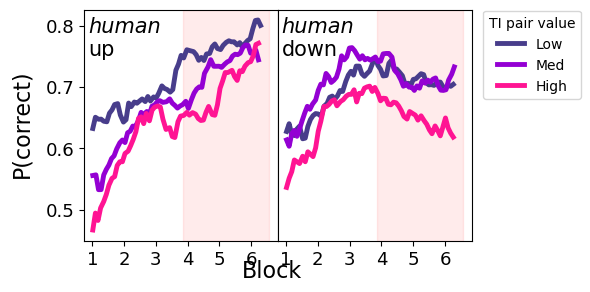

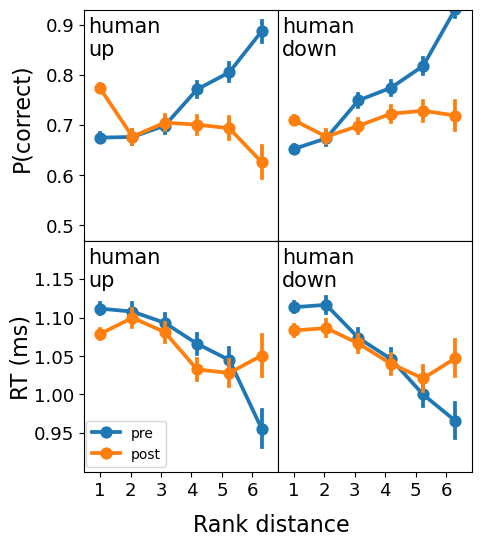

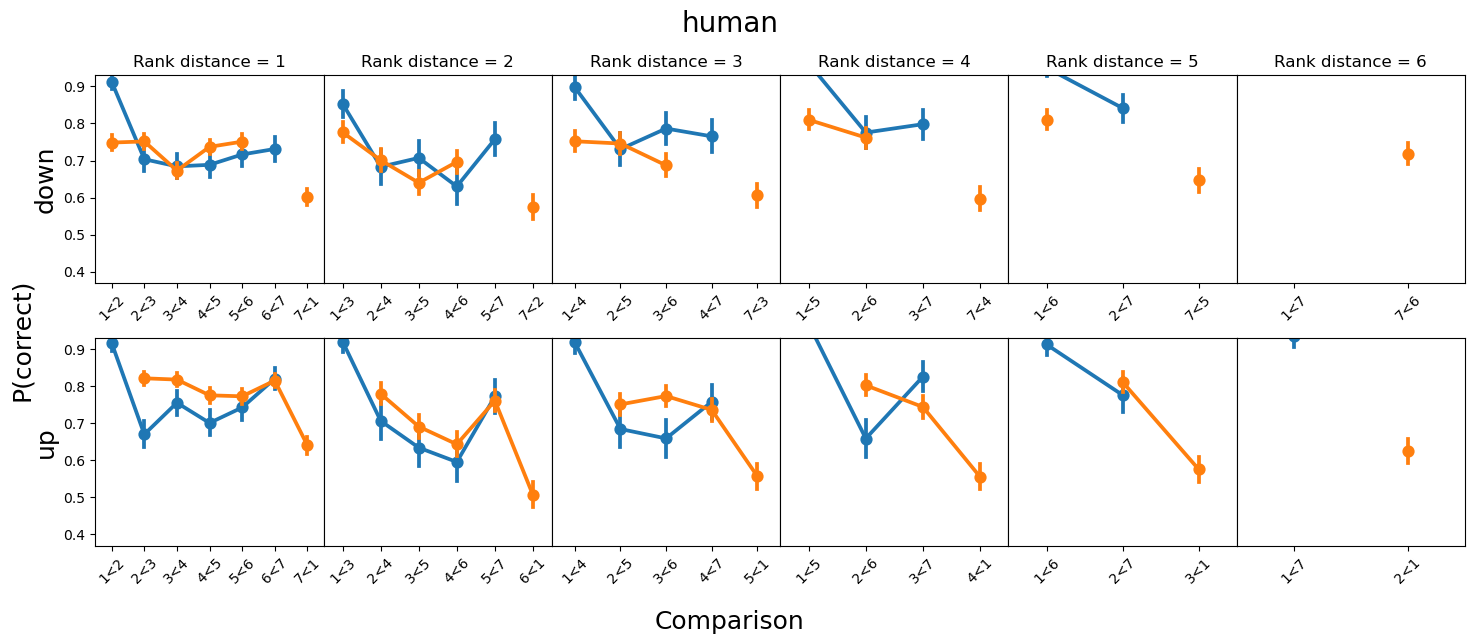

In [4]:
## plot human accuracy 
subplot_splits = [
    ['up','human'],
    ['down','human'],
]
subplot_dims = [1,2]
extremes = False
value_split = 'lmh'
plot_split = False
bin_width = 100
step = 5
min_periods = 1
figs_accs, axs = plotter.low_med_high(all_data, subplot_splits, subplot_dims,value_split, plot_split, bin_width, step, min_periods, extremes)

## repeat accuracy plots with median split
median_split = False
if median_split:
    for ps in [good_ps, bad_ps]:
        data = all_data.loc[all_data['Participant'].isin(ps)]
        figs_accs, axs = plotter.low_med_high(data, subplot_splits, subplot_dims,'lmh', plot_split, bin_width, step, min_periods, extremes)#, titles[value_split])

## SDE
SDE_type = 'acc'
extremes = True
figs_SDE, axs = plotter.SDE(all_data, subplot_splits, [2,2], extremes)

## all comparisons
figs, axs = plotter.all_comparisons(all_data, 'human',extremes = extremes)

## Choice matrices

-0.5416267942583731 0.21411042661042665
-0.5416267942583731 0.21411042661042665
-0.5562409812409813 0.16562762634191208
-0.5562409812409813 0.16562762634191208


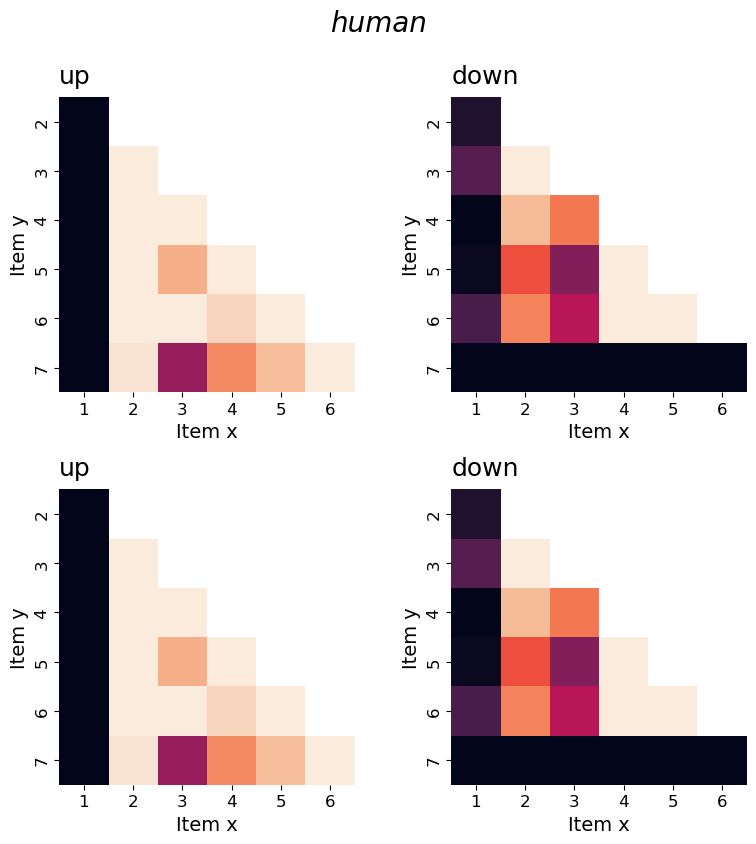

<Figure size 640x480 with 0 Axes>

In [15]:
import plotter
importlib.reload(plotter)
import plotter

## plot
plot_setting = 3
if (plot_setting == 1) or (plot_setting == 2):
    vmin = 0.5
    vmax = 0.8
elif plot_setting == 3:
    vmin = -0.12
    vmax = 0.12
figs, _ = plotter.plot_cm(all_data, 'halfway', vmin, vmax, plot_setting, 'acc', 'human')


## Anchor preference changes

Changes in selection of item 1 in post-switch relative to pre-switch
down:  0.0748327821625391 , SE =  0.029968744451272577 , t =  2.497027604350019 , p =  0.016432575535342588
up:  0.4133264486304443 , SE =  0.06295543742042489 , t =  6.565381253253704 , p =  9.580704331098937e-08

Changes in selection of item 7 in post-switch relative to pre-switch
down:  -0.3242017490455475 , SE =  0.04326258394779513 , t =  -7.493813810029495 , p =  2.4981833121437608e-09
up:  0.06898995873919815 , SE =  0.023572264009214666 , t =  2.926743002378948 , p =  0.005755110566825516

ttest of moved item preference change (down-7 vs up-1): t =  1.1886452055367553 , p =  0.23805254320194819
ttest of unmoved item preference change (down-1 vs up-7): t =  -0.1505391742211034 , p =  0.8807134983346971
anchor  1


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Direction,1.228515,1,81,1.228515,24.543804,3.907250e-06,0.232546,NaN
1,Block,2.270122,1,81,2.270122,48.562009,7.751900e-10,0.374817,1.0
2,Interaction,1.184432,1,81,1.184432,25.337148,2.853197e-06,0.238272,NaN


,Contrast,Direction,A,B,mean(A),std(A),SE(A),mean(B),std(B),SE(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Direction,-,down,up,0.187372,0.137089,0.020667,0.359739,0.179111,0.028681,False,True,-4.875865,70.831549,two-sided,6.419684e-06,NaN,NaN,3036.294,-1.079441
1,Block,-,post,pre,0.385306,0.326868,0.035878,0.151422,0.134921,0.014810,True,True,6.119455,82.000000,two-sided,3.068883e-08,NaN,NaN,3.96e+05,0.931078
2,Direction * Block,down,post,pre,0.224788,0.193746,0.029208,0.149955,0.140742,0.021218,True,True,2.497028,43.000000,two-sided,1.643258e-02,3.286515e-02,bonf,2.582,0.438068
3,Direction * Block,up,post,pre,0.566403,0.352967,0.056520,0.153076,0.129853,0.020793,True,True,6.565381,38.000000,two-sided,9.580704e-08,1.916141e-07,bonf,1.533e+05,1.538825


anchor  7


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Direction,1.733634,1,81,1.733634,23.202211,6.690635e-06,0.222665,NaN
1,Block,0.807010,1,81,0.807010,29.953366,4.819334e-07,0.269964,1.0
2,Interaction,1.598151,1,81,1.598151,59.317728,2.897524e-11,0.422739,NaN


,Contrast,Direction,A,B,mean(A),std(A),SE(A),mean(B),std(B),SE(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Direction,-,down,up,0.540366,0.203786,0.030722,0.745125,0.180668,0.028930,False,True,-4.852195,80.999764,two-sided,5.829960e-06,NaN,NaN,2793.242,-1.049524
1,Block,-,post,pre,0.566854,0.333108,0.036563,0.706303,0.173468,0.019041,True,True,-4.183825,82.000000,two-sided,7.150206e-05,NaN,NaN,267.649,-0.522693
2,Direction * Block,down,post,pre,0.378265,0.307468,0.046353,0.702467,0.172330,0.025980,True,True,-7.493814,43.000000,two-sided,2.498183e-09,4.996367e-09,bonf,4.746e+06,-1.289421
3,Direction * Block,up,post,pre,0.779620,0.211719,0.033902,0.710630,0.176896,0.028326,True,True,2.926743,38.000000,two-sided,5.755111e-03,1.151022e-02,bonf,6.614,0.350137


anchor  moved


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Direction,0.412625,1,81,0.412625,5.561525,2.076996e-02,0.064249,NaN
1,Block,5.561593,1,81,5.561593,95.697002,2.270178e-15,0.541588,1.0
2,Interaction,0.082112,1,81,0.082112,1.412877,2.380525e-01,0.017144,NaN


,Contrast,Direction,A,B,mean(A),std(A),SE(A),mean(B),std(B),SE(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Direction,-,down,up,0.459634,0.203786,0.030722,0.359739,0.179111,0.028681,False,True,2.376820,80.99611,two-sided,1.982147e-02,NaN,NaN,2.576,0.513836
1,Block,-,post,pre,0.595735,0.328756,0.036086,0.229656,0.169259,0.018579,True,True,9.757949,82.00000,two-sided,2.248263e-15,NaN,NaN,2.964e+12,1.393690
2,Direction * Block,down,post,pre,0.621735,0.307468,0.046353,0.297533,0.172330,0.025980,True,True,7.493814,43.00000,two-sided,2.498183e-09,4.996367e-09,bonf,4.746e+06,1.289421
3,Direction * Block,up,post,pre,0.566403,0.352967,0.056520,0.153076,0.129853,0.020793,True,True,6.565381,38.00000,two-sided,9.580704e-08,1.916141e-07,bonf,1.533e+05,1.538825


anchor  unmoved


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Direction,12.863345,1,81,12.863345,254.318246,1.040814e-26,0.758438,NaN
1,Block,0.215658,1,81,0.215658,13.848753,3.642988e-04,0.146009,1.0
2,Interaction,0.000353,1,81,0.000353,0.022662,8.807135e-01,0.000280,NaN


,Contrast,Direction,A,B,mean(A),std(A),SE(A),mean(B),std(B),SE(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Direction,-,down,up,0.187372,0.137089,0.020667,0.745125,0.180668,0.028930,False,True,-15.687587,70.464348,two-sided,1.098094e-24,NaN,NaN,7.31e+22,-3.474694
1,Block,-,post,pre,0.485492,0.343617,0.037717,0.413405,0.322719,0.035423,True,True,3.743769,82.000000,two-sided,3.354199e-04,NaN,NaN,64.495,0.215273
2,Direction * Block,down,post,pre,0.224788,0.193746,0.029208,0.149955,0.140742,0.021218,True,True,2.497028,43.000000,two-sided,1.643258e-02,0.032865,bonf,2.582,0.438068
3,Direction * Block,up,post,pre,0.779620,0.211719,0.033902,0.710630,0.176896,0.028326,True,True,2.926743,38.000000,two-sided,5.755111e-03,0.011510,bonf,6.614,0.350137


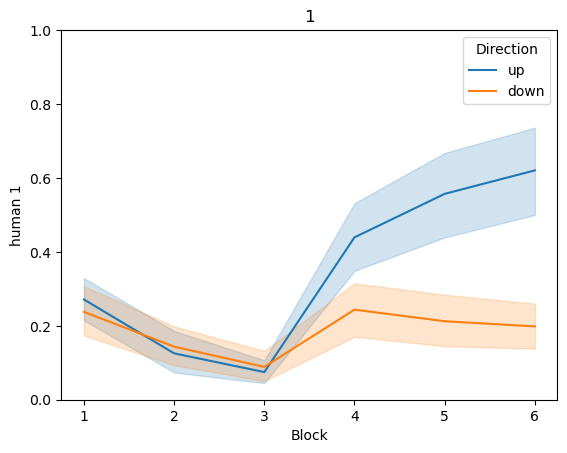

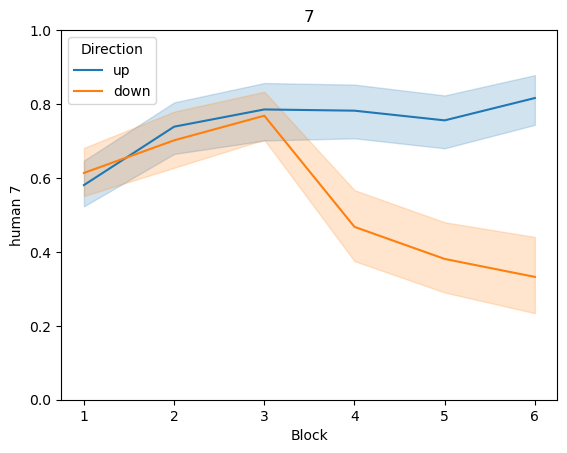

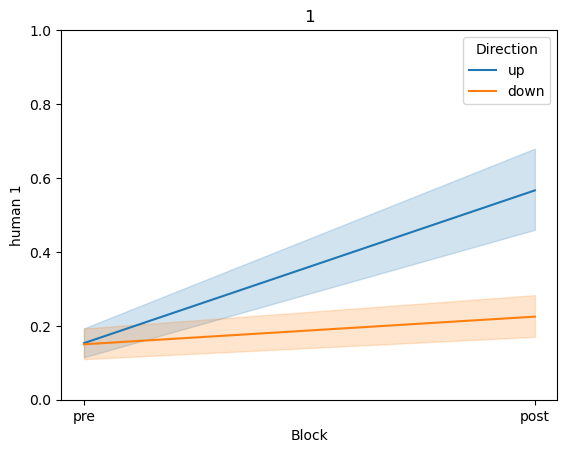

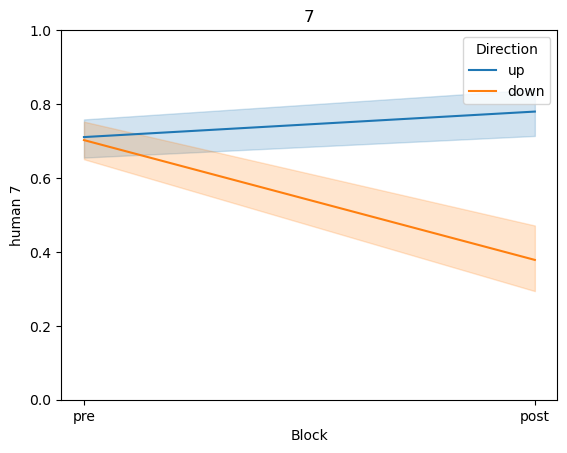

In [16]:
## calculate + plot the change in preference for each anchor (1,7)
model = 'human'
df_prefs = plotter.pref_change(all_data, model, plot = True)

## 2-way ANOVA on each anchor w/ post-hocs
for anchor in [1,7]:
    print('anchor ',anchor)
    anova = pg.mixed_anova(data = df_prefs.loc[(df_prefs['Block']=='pre') | (df_prefs['Block']=='post')],
                        dv = model+' '+str(anchor),
                        between = 'Direction',
                        within = 'Block',
                        subject = 'Participant',
    )
    display(anova)

    posthoc = pg.pairwise_tests(data = df_prefs.loc[(df_prefs['Block']=='pre') | (df_prefs['Block']=='post')],
                                dv = model+' '+str(anchor),
                                within = 'Block',
                                subject = 'Participant',
                                between = 'Direction',
                                padjust = 'bonf',
                                within_first = False, 
                                return_desc= True,
                                interaction = True
    )
    display(posthoc)

## repeat, but with the absolute change in preference
for anchor in ['moved', 'unmoved']:
    print('anchor ',anchor)
    anova = pg.mixed_anova(data = df_prefs.loc[(df_prefs['Block']=='pre') | (df_prefs['Block']=='post')],
                        dv = model+' '+anchor,
                        between = 'Direction',
                        within = 'Block',
                        subject = 'Participant',
    )
    display(anova)

    posthoc = pg.pairwise_tests(data = df_prefs.loc[(df_prefs['Block']=='pre') | (df_prefs['Block']=='post')],
                                dv = model+' '+anchor,
                                within = 'Block',
                                subject = 'Participant',
                                between = 'Direction',
                                padjust = 'bonf',
                                within_first = False,
                                return_desc= True,
                                interaction = True
    )
    display(posthoc)

## Asymm metrics

up
pre-switch: ß =  -0.022920512535897154 , t =  -5.461554223894449 , p =  8.983887975951057e-08
post-switch: ß =  0.02470603470603472 , t =  3.9846313256276846 , p =  8.230577907751961e-05

down
pre-switch: ß =  -0.021980021241384876 , t =  -5.606702682842933 , p =  3.885188856781964e-08
post-switch: ß =  -0.023948098408325676 , t =  -4.388978468020533 , p =  1.4644510671480537e-05

do people exhibit a significant asymmetry in pre switch bhvr?
down
mean asymm pre:  -0.021980021241384876 , SE =  0.006004768719506156 , t-test vs 0: t =  -3.618592782416489 , p =  0.0007744008118503725
up
mean asymm pre:  -0.02292051253589715 , SE =  0.006678872435002064 , t-test vs 0: t =  -3.3875106638460215 , p =  0.0016532367281237726

is pre-switch asymmetry different between groups?
t =  0.10373409813600974 , p =  0.917636780606305

is post-switch asymmetry different between groups?
t =  -4.353780281432465 , p =  3.8798038007752616e-05

down n_compressed =  32
down n_anti-compressed =  12
up n_compr

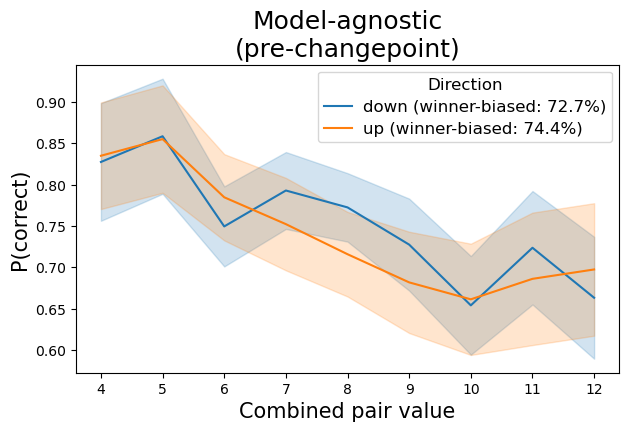

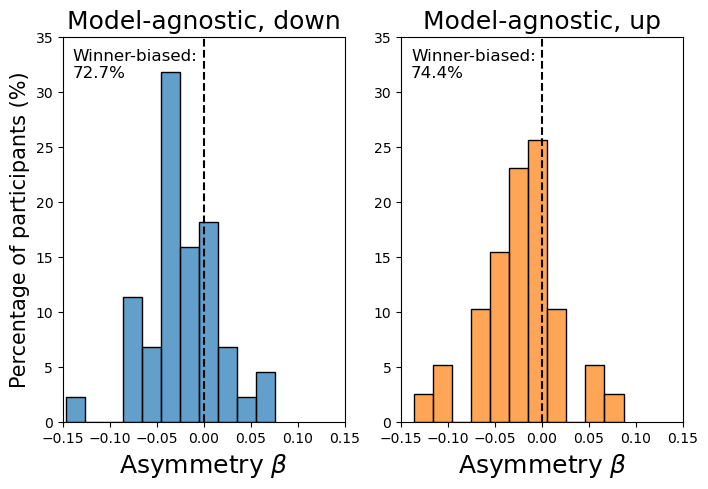

In [17]:
## calculate model-agnostic asymm metric (i.e. slope of asymm)
model = 'human'
asymms, slopes = asymm_metric(all_data, model, adj = False, extremes = True, split = 'halfway')
df_metrics = all_data.groupby(['Participant', 'Direction'], as_index = False).mean('Accuracy human')[['Participant','Direction']]
df_metrics[model +' pre-switch asymm slope'] = slopes[0,:]
df_metrics[model +' post-switch asymm slope'] = slopes[1,:]

## plot curve for all Ps
figs_asymm = plotter.plot_asymm(asymms, df_metrics, model, ['pre'])

## plot asymm betas per direction
figs_asymm_beta, axs = plt.subplots(1,2, figsize = (8,5))
colours = sns.color_palette()
for di, d in enumerate(directions):
    ax = axs[di]
    sns.histplot(data = df_metrics.loc[df_metrics['Direction']==d], x = model + ' pre-switch asymm slope', ax = ax, color = colours[di], alpha = 0.7, binwidth=0.02
                    , stat = 'percent', palette = 'magma')
    ax.axvline(x=0, color = 'black', linestyle = '--')
    ax.set_xlabel(r'Asymmetry $\beta$', fontsize = 18)
    ax.set_title('Model-agnostic, '+d, fontsize = 18)
    n_wb = len(df_metrics.loc[(df_metrics['Direction']==d) & (df_metrics[model + ' pre-switch asymm slope']<0)])
    n_lb = len(df_metrics.loc[(df_metrics['Direction']==d) & (df_metrics[model + ' pre-switch asymm slope']>0)])
    percentage = np.round(n_wb/(n_wb+n_lb)*100,1)
    ax.text(0.035, 0.97, 'Winner-biased:\n'+str(percentage)+'%', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.set_ylim([0,35])
    ax.set_xlim([-0.15, 0.15])
axs[0].set_ylabel('Percentage of participants (%)', fontsize = 15)
axs[1].set_ylabel('')


## check if asymm metric is sig different from 0
for switch in ['pre'
            #    , 'post'
               ]:
    print('do people exhibit a significant asymmetry in', switch, 'switch bhvr?')
    for d in directions:
        print(d)
        data = df_metrics.loc[(df_metrics['Direction']==d)
                              ][model + ' ' + switch + '-switch asymm slope']
        t, p = scipy.stats.ttest_1samp(data,0, alternative = 'two-sided')
        print('mean asymm pre: ', np.mean(data),', SE = ',np.std(data)/np.sqrt(len(data)),', t-test vs 0: t = ',t, ', p = ',p)
    print()


##check if asymmetry significantly differs between groups
print('is pre-switch asymmetry different between groups?')
t, p = scipy.stats.ttest_ind(df_metrics.loc[df_metrics['Direction']=='down', model + ' pre-switch asymm slope'], df_metrics.loc[df_metrics['Direction']=='up', model + ' pre-switch asymm slope'], alternative = 'two-sided')
print('t = ',t, ', p = ',p)
print()
print('is post-switch asymmetry different between groups?')
t, p = scipy.stats.ttest_ind(df_metrics.loc[df_metrics['Direction']=='down', model + ' post-switch asymm slope'], df_metrics.loc[df_metrics['Direction']=='up', model + ' post-switch asymm slope'], alternative = 'two-sided')
print('t = ',t, ', p = ',p)
print()

## count number of positive/negative slopes (i.e. number of 'compressed' vs 'anti-compressed' participants)
asymm_ps = {}
for d in directions:
    asymm_ps[d] = {}
    compressed = df_metrics.loc[(df_metrics['Direction']==d)
                             &(df_metrics[model + ' pre-switch asymm slope']<0), 'Participant'].to_numpy()
    asymm_ps[d]['model-free wb'] = compressed
    print(d, 'n_compressed = ',len(compressed))
    
    anti_compressed = df_metrics.loc[(df_metrics['Direction']==d)
                             &(df_metrics[model + ' pre-switch asymm slope']>0), 'Participant'].to_numpy()
    asymm_ps[d]['model-free lb'] = anti_compressed
    print(d, 'n_anti-compressed = ',len(anti_compressed))
print()

# Some significance tests

### Group data

In [6]:
## group data for subsequent significance testing
extremes = False #i.e. no trials containing items 1 or 7. NB: we use extremes when analysing only pre-switch data, but not when analysing post-switch data
model = 'human'
# model = 'Q-asymm'
# model = 'Q-adapt'
data = all_data.copy()
min_block = 0
if extremes: 
    df_acc = data.loc[(data['Feedback_on'] == 0)].groupby(['Participant','Direction'], as_index = False).mean('Accuracy '+model)[['Participant','Direction','Accuracy '+model]]
    df_acc_by_block = data.loc[(data['Feedback_on']==0) & (data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Block','Direction']].groupby(['Participant','Direction','Block'], as_index = False).mean('Accuracy '+model)
    df_acc_by_switch = data.loc[data['Feedback_on']==0][['Participant', 'Accuracy '+model, 'Switched','Direction']].groupby(['Participant','Direction','Switched'], as_index = False).mean('Accuracy '+model)
    df_acc_by_block_and_switch = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items))) &(data['Feedback_on']==0) & (data['Item_distance']>1) & (data['Block']>=min_block) & ((data['Block']<4) | ((data['Block']>=4) & (data['Switched']=='post')))][['Participant', 'Accuracy '+model, 'Block','Direction']].groupby(['Participant','Direction','Block'], as_index = False).mean('Accuracy '+model)
    df_acc_by_block_and_value = data.loc[(data['Feedback_on']==0) & (data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Block','Direction', 'Combined_value']].groupby(['Participant','Direction','Block', 'Combined_value'], as_index = False).mean('Accuracy '+model)
    df_acc_by_switch_and_value = data.loc[(data['Feedback_on']==0) & (data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Switched','Direction', 'Combined_value']].groupby(['Participant','Direction','Switched', 'Combined_value'], as_index = False).mean('Accuracy '+model)
    df_acc_by_distance = data.loc[(data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Rank_distance','Direction']].groupby(['Participant','Direction','Rank_distance'], as_index = False).mean('Accuracy '+model)
    df_acc_by_block_and_distance = data.loc[(data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Block', 'Rank_distance','Direction']].groupby(['Participant','Direction','Block','Rank_distance'], as_index = False).mean('Accuracy '+model)
    df_acc_by_switch_and_distance = data.loc[(data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Switched', 'Rank_distance','Direction']].groupby(['Participant','Direction','Switched','Rank_distance'], as_index = False).mean('Accuracy '+model)
    df_adj_acc_by_switch = data.loc[data['Feedback_on']==1][['Participant', 'Accuracy '+model, 'Switched','Direction']].groupby(['Participant','Direction','Switched'], as_index = False).mean('Accuracy '+model)
    df_adj_acc_by_block = data.loc[(data['Feedback_on']==1) & (data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Block','Direction']].groupby(['Participant','Direction','Block'], as_index = False).mean('Accuracy '+model)
else: 
    df_acc = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items))) &(data['Feedback_on'] == 0) & (data['Item_distance']>1)& (data['Block']>=min_block)].groupby(['Participant','Direction'], as_index = False).mean('Accuracy '+model)[['Participant','Direction','Accuracy '+model]]
    df_acc_by_block = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items))) &(data['Feedback_on']==0) & (data['Item_distance']>1) & (data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Block','Direction']].groupby(['Participant','Direction','Block'], as_index = False).mean('Accuracy '+model)
    df_acc_by_switch = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items))) &(data['Feedback_on']==0) & (data['Item_distance']>1) & (data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Switched','Direction']].groupby(['Participant','Direction','Switched'], as_index = False).mean('Accuracy '+model)
    df_acc_by_block_and_switch = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items))) &(data['Feedback_on']==0) & (data['Item_distance']>1) & (data['Block']>=min_block) & ((data['Block']<4) | ((data['Block']>=4) & (data['Switched']=='post')))][['Participant', 'Accuracy '+model, 'Block','Direction']].groupby(['Participant','Direction','Block'], as_index = False).mean('Accuracy '+model)
    df_acc_by_block_and_value = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items))) & (data['Feedback_on']==0) & (data['Item_distance']>1)& (data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Block','Direction', 'Combined_value']].groupby(['Participant','Direction','Block', 'Combined_value'], as_index = False).mean('Accuracy '+model)
    df_acc_by_switch_and_value = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items))) &(data['Feedback_on']==0) & (data['Item_distance']>1)& (data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Switched','Direction', 'Combined_value']].groupby(['Participant','Direction','Switched', 'Combined_value'], as_index = False).mean('Accuracy '+model)
    df_acc_by_distance = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items))) & (data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Rank_distance','Direction']].groupby(['Participant','Direction','Rank_distance'], as_index = False).mean('Accuracy '+model)
    df_acc_by_block_and_distance = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items)))  & (data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Block', 'Rank_distance','Direction']].groupby(['Participant','Direction','Block','Rank_distance'], as_index = False).mean('Accuracy '+model)
    df_acc_by_switch_and_distance = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items))) ][['Participant', 'Accuracy '+model, 'Switched', 'Rank_distance','Direction']].groupby(['Participant','Direction','Switched','Rank_distance'], as_index = False).mean('Accuracy '+model)
    df_adj_acc_by_switch = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items))) &(data['Feedback_on']==1)][['Participant', 'Accuracy '+model, 'Switched','Direction']].groupby(['Participant','Direction','Switched'], as_index = False).mean('Accuracy '+model)
    df_adj_acc_by_block = data.loc[(data['Item_1'].isin(np.arange(2,n_items))) & (data['Item_2'].isin(np.arange(2,n_items))) &(data['Feedback_on']==1) & (data['Block']>=min_block)][['Participant', 'Accuracy '+model, 'Block','Direction']].groupby(['Participant','Direction','Block'], as_index = False).mean('Accuracy '+model)

### Simple checks

In [29]:
## simple checks to see if acc is above chance
print('Is adj accuracy above chance?')
for d in directions:
    print(d)
    for switch in ['pre','post']:
        tt1 = df_adj_acc_by_switch.loc[(df_adj_acc_by_switch['Switched']==switch)
                                       &(df_adj_acc_by_switch['Direction']==d)
                                       , 'Accuracy '+model]
        ttest = scipy.stats.ttest_1samp(tt1-0.5,0)
        print(switch,': mean = ',np.mean(tt1),', SE = ', np.std(tt1)/np.sqrt(len(tt1)),', t = ',ttest.statistic,', p = ',ttest.pvalue)
    print()

print()

print('Is TI accuracy above chance?')
for d in directions:
    print(d)
    for switch in ['pre','post']:
        tt1 = df_acc_by_switch.loc[(df_acc_by_switch['Switched']==switch)
                                   &(df_acc_by_switch['Direction']==d)
                                   , 'Accuracy '+model]
        ttest = scipy.stats.ttest_1samp(tt1-0.5,0)
        print(switch,': mean = ',np.mean(tt1),', SE = ', np.std(tt1)/np.sqrt(len(tt1)),', t = ',ttest.statistic,', p = ',ttest.pvalue)
    print()
print()


Is adj accuracy above chance?
down
pre : mean =  0.60221737504152 , SE =  0.016286790675083936 , t =  6.204361566284053 , p =  1.8437358288479172e-07
post : mean =  0.7282603075789965 , SE =  0.026595039423656576 , t =  8.484722623570175 , p =  9.865510816860675e-11

up
pre : mean =  0.6376085754244599 , SE =  0.017250176782991927 , t =  7.874290693907414 , p =  1.6675611219096124e-09
post : mean =  0.7985828274373445 , SE =  0.024360429904993125 , t =  12.098718517128715 , p =  1.3301549389616924e-14


Is TI accuracy above chance?
down
pre : mean =  0.6687642439827557 , SE =  0.024517042095443174 , t =  6.8048766148515405 , p =  2.4679971952233537e-08
post : mean =  0.7030307762415965 , SE =  0.03150693425625756 , t =  6.370354750278859 , p =  1.0570046616003823e-07

up
pre : mean =  0.6283221150383193 , SE =  0.030009567282705697 , t =  4.2208631416377065 , p =  0.000145852678768394
post : mean =  0.7384718139580568 , SE =  0.033484557106080844 , t =  7.029946032393168 , p =  2.24034

### SDEs

In [7]:
## symbolic distance effects

# linear regression of accuracy on distance
print('SDE: accuracy')
for d in directions:
    print(d)
    data = df_acc_by_switch_and_distance.loc[(df_acc_by_switch_and_distance['Switched']=='pre')
                                             &(df_acc_by_switch_and_distance['Direction']==d)
                                             ]
    X = data['Rank_distance']
    y = data['Accuracy '+model]
    X = sm.add_constant(X)
    reg = sm.OLS(y, X).fit()
    print('pre-switch: ß = ',reg.params[1],', t = ',reg.tvalues[1], ', p = ',reg.pvalues[1])
print()

# linear regression of RT on distance
print('SDE: RTs')
df_RT_by_switch_and_distance = all_data.loc[(all_data['Block']>=min_block)][['Participant', 'RT', 'Switched', 'Rank_distance','Direction']].groupby(['Participant','Direction','Switched','Rank_distance'], as_index = False).mean('RT')
for d in directions:
    print(d)
    data = df_RT_by_switch_and_distance.loc[(df_RT_by_switch_and_distance['Switched']=='pre')
                                             &(df_RT_by_switch_and_distance['Direction']==d),
                                             ]
    X = data['Rank_distance']
    y = data['RT']
    X = sm.add_constant(X)
    reg = sm.OLS(y, X).fit()
    print('pre-switch: ß = ',reg.params[1],', t = ',reg.tvalues[1], ', p = ',reg.pvalues[1])
print()

SDE: accuracy
down
pre-switch: ß =  0.05238419010202961 , t =  11.070373715376373 , p =  1.2747431452952668e-23
up
pre-switch: ß =  0.043292903499719655 , t =  8.301142650054581 , p =  8.529004876554846e-15

SDE: RTs
down
pre-switch: ß =  -0.03201223303577584 , t =  -5.243869587681475 , p =  3.2429643634047575e-07
up
pre-switch: ß =  -0.029014067462127893 , t =  -4.109286841483193 , p =  5.506904527129981e-05



### 2-way ANOVAs

In [7]:
### ANOVAs
print('Adjacent trials:')

## 2-way: switch (pre vs post) x direction (up vs down) ANOVA (adj trials):
print('adj switch x direction ANOVA')
ANOVA = pg.mixed_anova(data = df_adj_acc_by_switch,
                     dv = 'Accuracy '+model,
                     within = 'Switched',
                     subject = 'Participant',
                     between = 'Direction',
)
display(ANOVA)

#post-hoc tests
print('post-hoc switch x direction tests:')
post_hoc = pg.pairwise_tests(data = df_adj_acc_by_switch,
                    dv = 'Accuracy '+model,
                    within = 'Switched',
                    subject = 'Participant',
                    between = 'Direction',
                    padjust = 'bonf',
                    return_desc= True,

    )
display(post_hoc)
print()
print()    


## 2-way: block (block 3 vs post-switch 1 vs post-switch 2) x direction (up vs down) ANOVA (adj trials):
pre_post_post = all_data.loc[all_data['Switched']=='post'].copy()
pre_post_post['Block_2'] = np.zeros(len(pre_post_post))
# pre_post_post.loc[pre_post_post['Switched']=='pre', 'Block_2'] = 1
pre_post_post.loc[(pre_post_post['Switched']=='post') & (pre_post_post['Trial']<half_b_starts[9]), 'Block_2'] = 2
pre_post_post.loc[(pre_post_post['Switched']=='post') & (pre_post_post['Trial']>=half_b_starts[9]), 'Block_2'] = 3
df_pre_post_post_adj = pre_post_post.loc[(pre_post_post['Item_1'].isin(np.arange(2,n_items))) & (pre_post_post['Item_2'].isin(np.arange(2,n_items))) &(pre_post_post['Feedback_on']==1)][['Participant', 'Accuracy '+model, 'Block_2','Direction']].groupby(['Participant','Direction','Block_2'], as_index = False).mean('Accuracy '+model)
print('adj post-CP half x direction ANOVA')
ANOVA = pg.mixed_anova(data = df_pre_post_post_adj,
                     dv = 'Accuracy '+model,
                     within = 'Block_2',
                     subject = 'Participant',
                     between = 'Direction',
)
display(ANOVA)

# # post-hoc tests
print('post-hoc post-CP half x direction tests:')
post_hoc = pg.pairwise_tests(data = df_pre_post_post_adj,
                    dv = 'Accuracy '+model,
                    subject = 'Participant',
                    between = 'Direction',
                    within = 'Block_2',
                    padjust = 'bonf',
                    within_first = False,
                    return_desc= True,

    )
display(post_hoc)
print()
print()  

print()
print()
print()
print()
print('Non-adjacent trials:')  

## 2-way: switch (pre vs post) x direction (up vs down) ANOVA (non-adj):
print('non-adj switch x direction ANOVA')
ANOVA = pg.mixed_anova(data = df_acc_by_switch,
                     dv = 'Accuracy '+model,
                     within = 'Switched',
                     subject = 'Participant',
                     between = 'Direction',

)
display(ANOVA)

#post-hoc tests
print('post-hoc switch x direction tests:')
post_hoc = pg.pairwise_tests(data = df_acc_by_switch,
                    dv = 'Accuracy '+model,
                    subject = 'Participant',
                    between = 'Direction',
                    within = 'Switched',
                    padjust = 'bonf',
                    within_first = False,
                    return_desc= True,

    )
display(post_hoc)
print()
print()    

## 2-way: post-changepoint half (post-switch 1 vs post-switch 2) x direction (up vs down) ANOVA (non-adj):
pre_post_post = all_data.loc[all_data['Switched']=='post'].copy()
pre_post_post['Block_2'] = np.zeros(len(pre_post_post))
# pre_post_post.loc[pre_post_post['Switched']=='pre', 'Block_2'] = 1
pre_post_post.loc[(pre_post_post['Switched']=='post') & (pre_post_post['Trial']<half_b_starts[9]), 'Block_2'] = 2
pre_post_post.loc[(pre_post_post['Switched']=='post') & (pre_post_post['Trial']>=half_b_starts[9]), 'Block_2'] = 3
df_pre_post_post = pre_post_post.loc[(pre_post_post['Item_1'].isin(np.arange(2,n_items))) & (pre_post_post['Item_2'].isin(np.arange(2,n_items))) &(pre_post_post['Feedback_on']==0) & (pre_post_post['Item_distance']>1)][['Participant', 'Accuracy '+model, 'Block_2','Direction']].groupby(['Participant','Direction','Block_2'], as_index = False).mean('Accuracy '+model)

print('non-adj post-CP half x direction ANOVA')
ANOVA = pg.mixed_anova(data = df_pre_post_post,
                     dv = 'Accuracy '+model,
                     within = 'Block_2',
                     subject = 'Participant',
                     between = 'Direction',
)
display(ANOVA)

# # post-hoc tests
print('post-hoc post-CP half x direction tests:')
post_hoc = pg.pairwise_tests(data = df_pre_post_post,
                    dv = 'Accuracy '+model,
                    subject = 'Participant',
                    between = 'Direction',
                    within = 'Block_2',
                    padjust = 'bonf',
                    within_first = False,
                    return_desc= True,

    )
display(post_hoc)
print()
print()  

Adjacent trials:
adj switch x direction ANOVA


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Direction,0.115524,1,81,0.115524,3.870756,5.255735e-02,0.045608,NaN
1,Switched,0.842194,1,81,0.842194,83.130771,4.651133e-14,0.506491,1.0
2,Interaction,0.012614,1,81,0.012614,1.245055,2.677983e-01,0.015138,NaN


post-hoc switch x direction tests:


,Contrast,Switched,A,B,mean(A),std(A),SE(A),mean(B),std(B),SE(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Switched,-,post,pre,0.761303,0.170157,0.018677,0.618847,0.109991,0.012073,True,True,9.104014,82.000000,two-sided,4.469270e-14,NaN,NaN,1.632e+11,0.989782
1,Direction,-,down,up,0.665239,0.126370,0.019051,0.718096,0.117210,0.018769,False,True,-1.976455,80.822315,two-sided,5.151429e-02,NaN,NaN,1.234,-0.428673
2,Switched * Direction,post,down,up,0.728260,0.178451,0.026903,0.798583,0.154120,0.024679,False,True,-1.926253,80.951898,two-sided,5.758279e-02,0.115166,bonf,1.135,-0.415994
3,Switched * Direction,pre,down,up,0.602217,0.109283,0.016475,0.637609,0.109136,0.017476,False,True,-1.473575,79.834015,two-sided,1.445283e-01,0.289057,bonf,0.588,-0.321044




adj post-CP half x direction ANOVA


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Direction,0.195619,1,81,0.195619,3.474738,0.065936,0.041133,NaN
1,Block_2,0.084785,1,81,0.084785,9.180780,0.003282,0.101804,1.0
2,Interaction,0.024027,1,81,0.024027,2.601701,0.110639,0.031120,NaN


post-hoc post-CP half x direction tests:


,Contrast,Direction,A,B,mean(A),std(A),SE(A),mean(B),std(B),SE(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Direction,-,down,up,0.728291,0.178121,0.026853,0.797072,0.155241,0.024859,False,True,-1.879659,80.981008,two-sided,0.063751,NaN,NaN,1.053,-0.406152
1,Block_2,-,2.0,3.0,0.738010,0.192108,0.021087,0.783210,0.174662,0.019172,True,True,-3.000814,82.000000,two-sided,0.003566,NaN,NaN,7.625,-0.245069
2,Direction * Block_2,down,2.0,3.0,0.717017,0.192706,0.029051,0.739564,0.191439,0.028860,True,True,-1.040481,43.000000,two-sided,0.303932,0.607863,bonf,0.271,-0.116358
3,Direction * Block_2,up,2.0,3.0,0.761693,0.191129,0.030605,0.832451,0.140233,0.022455,True,True,-3.494282,38.000000,two-sided,0.001225,0.002449,bonf,25.694,-0.417940








Non-adjacent trials:
non-adj switch x direction ANOVA


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Direction,0.000259,1,81,0.000259,0.003923,0.950215,0.000048,NaN
1,Switched,0.202900,1,81,0.202900,19.999104,0.000025,0.198013,1.0
2,Interaction,0.059525,1,81,0.059525,5.867173,0.017658,0.067542,NaN


post-hoc switch x direction tests:


,Contrast,Direction,A,B,mean(A),std(A),SE(A),mean(B),std(B),SE(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Direction,-,down,up,0.685898,0.173799,0.026201,0.683397,0.189916,0.030411,False,True,0.062294,77.57768,two-sided,0.950489,NaN,NaN,0.229,0.013646
1,Switched,-,post,pre,0.719684,0.211071,0.023168,0.649761,0.176942,0.019422,True,True,4.344946,82.00000,two-sided,0.000040,NaN,NaN,462.6,0.357383
2,Direction * Switched,down,post,pre,0.703031,0.211410,0.031871,0.668764,0.164508,0.024800,True,True,1.508983,43.00000,two-sided,0.138617,0.277233,bonf,0.467,0.179324
3,Direction * Switched,up,post,pre,0.738472,0.211845,0.033922,0.628322,0.189860,0.030402,True,True,5.188560,38.00000,two-sided,0.000007,0.000015,bonf,2680.855,0.542171




non-adj post-CP half x direction ANOVA


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Direction,0.041353,1,81,0.041353,0.459007,0.500019,0.005635,NaN
1,Block_2,0.025785,1,81,0.025785,1.992244,0.161936,0.024005,1.0
2,Interaction,0.082690,1,81,0.082690,6.389018,0.013427,0.073110,NaN


post-hoc post-CP half x direction tests:


,Contrast,Direction,A,B,mean(A),std(A),SE(A),mean(B),std(B),SE(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Direction,-,down,up,0.703783,0.210404,0.031720,0.735407,0.214302,0.034316,False,True,-0.676743,79.431892,two-sided,0.500535,NaN,NaN,0.28,-0.147617
1,Block_2,-,2.0,3.0,0.706179,0.227554,0.024977,0.731106,0.226960,0.024912,True,True,-1.367256,82.000000,two-sided,0.175281,NaN,NaN,0.296,-0.109181
2,Direction * Block_2,down,2.0,3.0,0.712332,0.214159,0.032286,0.695234,0.239204,0.036061,True,True,0.665053,43.000000,two-sided,0.509568,1.000000,bonf,0.201,0.074658
3,Direction * Block_2,up,2.0,3.0,0.699238,0.244429,0.039140,0.771577,0.207936,0.033296,True,True,-3.027656,38.000000,two-sided,0.004411,0.008821,bonf,8.331,-0.315636


# Analyse model fits

### Load fits

In [33]:
## load relevant set of fits
# with open('fits/RL_entropy_final.pkl', 'rb') as f: ## full fits
#     df_fits_big = pickle.load(f)
with open('fits/RL_entropy_final_pre.pkl', 'rb') as f: ## fit to pre-switch only
    df_fits_big = pickle.load(f)
# with open('fits/RL_omi_final.pkl', 'rb') as f: ## Q-asymm^2 model fits
#     df_fits_big = pickle.load(f)
    
## keep models of interest
moi = [
        'Q-symm','Q-asymm',
        # 'Q-adapt',
        # 'Q-symm_m2','Q-asymm_m2',
        ]
# moi = df_fits_big.keys()
rm_models = []

## get best fit for each model-participant pair if using multiple parameter starting points (i.e. multiple x0s)
df_fits = best_x0(df_fits_big, moi)
for key in df_fits.keys():
    if key not in moi:
        rm_models.append(key)
        pass
    else:
        df_fits[key] = df_fits[key].loc[df_fits[key]['Participant'].isin(participants)]

## rename models in case the .pkl file was saved with different names
df_fits = rename_models(df_fits) 
print(df_fits.keys())

dict_keys(['Q-symm', 'Q-asymm'])


### Load NHB params

In [5]:
## load parameters for models fit to the 2022 NHB dataset
with open('fits/RL_NHB_fits.pkl', 'rb') as f:
    df_fits_big = pickle.load(f)

## clean
moi = ['Q1*','Q2*','Q3*']
df_fits = best_x0(df_fits_big, moi)

## rename a1-->a0 for Q3 models
for q3 in ['Q3*']:
    df_fits[q3] = df_fits[q3].rename(columns={'a1':'a0'})

## clean
rm_models = []
df_fits = best_x0(df_fits_big,moi)
for key in df_fits.keys():
    if key not in moi:
        rm_models.append(key)
        pass
df_fits = rename_models(df_fits)


## double the set of participants so that each odd-even pair has the same parameter estimates (i.e. so that we can simulate the same parameter settings in the down expt and the up expt)
NHB_fits = {}
for m, model in enumerate(df_fits.keys()):
    current_params = model_params[model]
    NHB_fits[model] = df_fits[model]
    NHB_fits[model]['Participant'] = [2*i+1 for i in range(len(df_fits[model]))]
    NHB_fits[model] = pd.concat([NHB_fits[model], NHB_fits[model]])
    NHB_fits[model].iloc[len(df_fits[model]):,0] = [2*i for i in range(len(df_fits[model]))]
    NHB_fits[model] = NHB_fits[model].sort_values('Participant')
    NHB_fits[model] = NHB_fits[model].reset_index()

NHB_participants = NHB_fits[model]['Participant'].to_list()
n_NHB_participants = len(NHB_participants)


### Calculate AIC and BIC

In [31]:
### calculate model evidence metrics

# initialise dataframes
loss = pd.DataFrame(columns=df_fits.keys())
AIC = pd.DataFrame(columns=df_fits.keys())
BIC = pd.DataFrame(columns=df_fits.keys())
pR_2 = pd.DataFrame(columns=df_fits.keys())
RL = TI_RL(n_items)

# loop through models
for m, model in enumerate(df_fits.keys()):
    
    # sort by participant number
    df_fits[model] = df_fits[model].sort_values('Participant').reset_index(drop=True)

    # add direction back in (in case missing)
    df_fits[model].loc[df_fits[model]['Participant'].isin(down_participants), 'Direction'] = 'down'
    df_fits[model].loc[df_fits[model]['Participant'].isin(up_participants), 'Direction'] = 'up'
    
    #add AIC and BIC columns to these data
    df_fits[model]['AIC'] = np.zeros((len(df_fits[model])))
    df_fits[model]['BIC'] = np.zeros((len(df_fits[model])))

    #calculate degrees of freedom for each model
    free = 0
    for par in all_params:
        if par in df_fits[model]:
            free +=1
    print(model, free)

    #calculate AIC and BIC
    df_fits[model]['AIC'] = 2 * free + df_fits[model]['loss'].to_numpy()
    df_fits[model]['BIC'] = np.log(df_fits[model]['n_trials']) * free + df_fits[model]['loss'].to_numpy()
    
    ## calculate pR^2 (can use either the AIC or BIC for this)
    evidence_metric = 'AIC'
    for p in participants:
        tmp_evidence = df_fits[model].loc[df_fits[model]['Participant'] == p, evidence_metric].to_numpy()
        tmp_n_trials = df_fits[model].loc[df_fits[model]['Participant'] == p, 'n_trials'].to_numpy()
        df_fits[model].loc[df_fits[model]['Participant']==p, 'pR_2'] = RL.pseudo_r_sq(tmp_evidence, tmp_n_trials, free)

    #create new df with AIC and AIC
    loss['Participant'] = df_fits[model]['Participant']
    AIC['Participant'] = df_fits[model]['Participant']
    BIC['Participant'] = df_fits[model]['Participant']
    pR_2['Participant'] = df_fits[model]['Participant']
    loss['Direction'] = df_fits[model]['Direction']
    AIC['Direction'] = df_fits[model]['Direction']
    BIC['Direction'] = df_fits[model]['Direction']
    pR_2['Direction'] = df_fits[model]['Direction']
    loss[model] = df_fits[model]['loss'].to_numpy()
    AIC[model] = df_fits[model]['AIC'].to_numpy()
    BIC[model] = df_fits[model]['BIC'].to_numpy()
    pR_2[model] = df_fits[model]['pR_2'].to_numpy()
loss = loss.set_index(['Participant', 'Direction'])
AIC = AIC.set_index(['Participant', 'Direction'])
BIC = BIC.set_index(['Participant', 'Direction'])
pR_2 = pR_2.set_index(['Participant','Direction'])

## choose which evidence metric to use for summary stats
evidence = AIC
# evidence = re_fit_AIC
# evidence = BIC

## summary stats per expt condition
for i, current_participants in enumerate([down_participants, up_participants]):
    d = directions[i]
    print(d)
    display(evidence.loc[(evidence.index.get_level_values('Direction')==d)
                            ].describe())
    print('SE = ',evidence.loc[(evidence.index.get_level_values('Participant').isin(current_participants))
                            ].std()/
                            np.sqrt(len(evidence.loc[(evidence.index.get_level_values('Participant').isin(current_participants))
                            ])))
    print()

## plot
# figs, axs = plotter.plot_evidence(evidence)

Q-symm 3
Q-asymm 4
Q-adapt 4
down


,Q-symm,Q-asymm,Q-adapt
count,44.000000,44.000000,44.000000
mean,366.122969,349.805425,348.366612
std,64.379150,69.392953,70.318459
min,221.509107,172.657149,172.025852
25%,340.164195,317.654378,306.283458
50%,383.196924,370.023371,364.622907
75%,411.296409,401.156312,401.451884
max,445.719194,442.410717,438.020859


SE =  Q-symm      9.705522
Q-asymm    10.461381
Q-adapt    10.600907
dtype: float64

up


,Q-symm,Q-asymm,Q-adapt
count,39.000000,39.000000,39.000000
mean,363.525443,339.258006,339.202242
std,68.630225,77.955941,78.984669
min,203.677181,161.177627,161.206156
25%,324.089065,285.676235,283.478838
50%,380.085870,365.207179,365.393269
75%,415.654299,393.637645,394.891736
max,449.015200,439.362732,436.121625


SE =  Q-symm     10.989631
Q-asymm    12.482941
Q-adapt    12.647669
dtype: float64



### Wilcoxon tests of AICs

In [28]:
## check diffs at overall level
print('overall:')
for model_comps in list(itertools.combinations(moi, 2)):
    m1 = model_comps[0]
    m2 = model_comps[1]
    print(m1, ' = ', evidence[m1].median())
    print(m2, ' = ', evidence[m2].median())
    wilc = stats.wilcoxon(evidence[m1], evidence[m2], method = 'approx', alternative = 'two-sided')
    print('z = ', wilc.zstatistic,'p =',np.round(wilc.pvalue,4))
    print()
    print()

## check diffs within each group of participants
for di, d in enumerate(directions):
    print(d+':')
    current_ps = all_participants[di]
    for model_comps in list(itertools.combinations(moi, 2)):
        m1 = model_comps[0]
        m2 = model_comps[1]
        print(m1, ' = ', evidence.loc[evidence.index.get_level_values('Participant').isin(current_ps), m1].mean())
        print(m2, ' = ', evidence.loc[evidence.index.get_level_values('Participant').isin(current_ps), m2].mean())
        wilc = stats.wilcoxon(evidence.loc[evidence.index.get_level_values('Participant').isin(current_ps), m1], evidence.loc[evidence.index.get_level_values('Participant').isin(current_ps), m2], method = 'approx', alternative = 'two-sided')
        print('z = ', wilc.zstatistic,'p =',np.round(wilc.pvalue,4))
        print()


overall:
Q-symm  =  382.64933676643136
Q-asymm  =  365.22903417469
z =  -7.414039248986289 p = 0.0


Q-symm  =  382.64933676643136
Q-adapt  =  365.3932691740767
z =  -6.710318438457891 p = 0.0


Q-asymm  =  365.22903417469
Q-adapt  =  365.3932691740767
z =  -0.4767140974547216 p = 0.6336


down:
Q-symm  =  366.122968869388
Q-asymm  =  349.80542482579045
z =  -5.2165760787799975 p = 0.0

Q-symm  =  366.122968869388
Q-adapt  =  348.3666121987028
z =  -4.738098183410915 p = 0.0

Q-asymm  =  349.80542482579045
Q-adapt  =  348.3666121987028
z =  -0.805243287328456 p = 0.4207

up:
Q-symm  =  363.5254429521102
Q-asymm  =  339.25800628232895
z =  -5.247079217201428 p = 0.0

Q-symm  =  363.5254429521102
Q-adapt  =  339.2022420325072
z =  -4.800519283822583 p = 0.0

Q-asymm  =  339.25800628232895
Q-adapt  =  339.2022420325072
z =  -0.2651449604436892 p = 0.7909



### Bayesian model comparison

down pxp:
['Q-symm = 0.006465357975535236', 'Q-asymm = 0.06722572930047982', 'Q-adapt = 0.926308912723985']
up pxp:
['Q-symm = 0.006767705437080894', 'Q-asymm = 0.5449909585176607', 'Q-adapt = 0.44824133604525845']


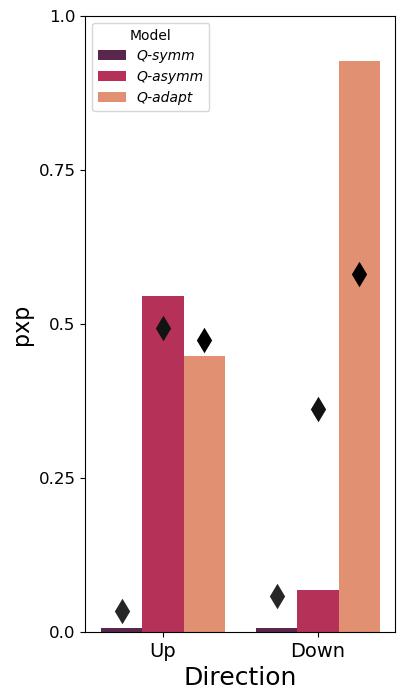

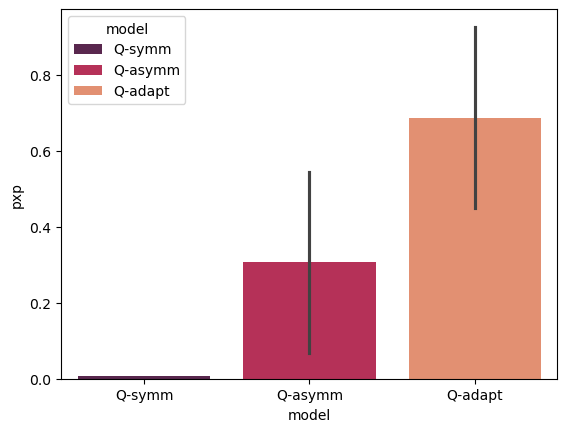

In [11]:
importlib.reload(plotter)
import plotter

## intialise
pxp = {
    'Direction': [],
    'model': [],
    'pxp': [],
    'freq': []
}
moi =  ['Q-symm','Q-asymm','Q-adapt']

##run BMC
for i, current_participants in enumerate([down_participants, up_participants]):
    d = directions[i]
    print(d, 'pxp:')
    L = -evidence.loc[(evidence.index.get_level_values('Participant').isin(current_participants))
                        ].loc[:,moi].to_numpy().T
    BMC_result = GroupBMC(L).get_result()
    for mi, m in enumerate(moi):
        pxp['Direction'].extend([d])
        pxp['model'].extend([m])
        pxp['pxp'].extend([BMC_result.protected_exceedance_probability[mi]])
        pxp['freq'].extend([BMC_result.frequency_mean[mi]])
    print([m+' = '+str(BMC_result.protected_exceedance_probability[mi]) for mi, m in enumerate(moi)])

df_pxp = pd.DataFrame(pxp)
df_pxp = df_pxp.sort_values(['Direction'])
figs, axs = plotter.plot_pxp(df_pxp)


# Simulations

### Simulate

In [15]:
import helpers
importlib.reload(helpers)
from helpers import *

In [34]:
import models 
importlib.reload(models)
from models import TI_RL

## define indices models of interest
moi_idx = np.array([
    [0,0], # Q-symm
    [0,1], # Q-asymm
    # [0,12], # Q-adapt
    # [2,1] # Q-asymm^2 (AKA Q-asymm_m2)
])
moi_names = [all_models[mmm[0]][mmm[1]] for m, mmm in enumerate(moi_idx)]

## determine which parameters to use
fit_params = 'empirical'
# fit_params = 'handpicked'
# fit_params = 'NHB_empirical'

participants.sort()
sim_participants = participants.copy()
n_sim_participants = len(sim_participants)

## generate trial sequences if using NHB parameters
if fit_params == 'NHB_empirical':

    ## trial/simulation info
    sim_data = pd.DataFrame()
    switch_block = 4
    switch_type = 'move'
    to_move = 1
    move_to = n_items
    switches = np.array(([to_move-1, move_to-1],
                    [move_to-1, to_move-1]))
    directions = ['up', 'down']

    ## generate trials
    for p_n, p in enumerate(NHB_participants):
        switch = switches[p%2]
        trials = generate_sequences(p, n_items, n_blocks, switch_block, switch, switch_type)
        sim_data = pd.concat((sim_data, trials))
        


## loop through models
for mi, moi in enumerate(moi_idx):
    m_s = moi[0]
    m = moi[1]
    current_model = moi_names[mi]
    print(current_model)
    print(model_params[current_model])


    ### get relevant params

    ## empirical params
    if fit_params == 'empirical':
        sim_params = df_fits[current_model][model_params[current_model]].to_numpy().squeeze()
        sim_participants = df_fits[current_model]['Participant'].to_numpy()
        sim_data = all_data.copy()
        fit = True

    ## hand-picked params
    elif fit_params == 'handpicked':

        ## initialise participants
        sim_participants = participants.copy()
        n_sim_participants = len(sim_participants)
        
        # set param means
        a1 = 0.05
        a2 = 0.015
        a0 = a1
        eta = 2
        tauI = 0.2
        tauP = 0.3
        gamma = 0.2
        lam = 1
        eps = 0.0
        omi1 = np.copy(a1)
        omi2 = np.copy(a2)
        disc = 0.01
        meta = 0.02
        
        # ND sample of parameters
        a1s = np.abs(np.random.normal(a1, 0.01, n_sim_participants))
        a2s = np.abs(np.random.normal(a2, 0.005, n_sim_participants))
        a0s = np.abs(np.random.normal(a0, 0.005, n_sim_participants))
        etas = np.abs(np.random.normal(eta, 1, n_sim_participants))
        tauIs = np.abs(np.random.normal(tauI, 0.1, n_sim_participants))
        tauPs = np.abs(np.random.normal(tauP, 0.1, n_sim_participants))
        gammas = np.abs(np.random.normal(gamma, 0.1, n_sim_participants))
        lams = np.abs(np.random.normal(lam, 0.1, n_sim_participants))
        epss = np.abs(np.random.normal(eps, 0.1, n_sim_participants))
        omi1s = np.abs(np.random.normal(omi1, 0.01, n_sim_participants))
        omi2s = np.abs(np.random.normal(omi2, 0.01, n_sim_participants))
        metas = np.abs(np.random.normal(meta, 0.0, n_sim_participants))
        params = np.array([a1s, a2s, a0s, etas, tauIs, tauPs, gammas, lams, epss, omi1s, omi2s, metas]).T
        sim_params = params[:, param_idx[m_s][m]]
        sim_data = all_data.copy()
        fit = False


    ## NHB params
    elif fit_params == 'NHB_empirical':
        sim_participants = NHB_fits[current_model]['Participant'].to_numpy()
        n_sim_participants = len(sim_participants)
        sim_params = NHB_fits[current_model][model_params[current_model]].to_numpy().squeeze()
        fit = False
        
    
    ## run simulation
    RL = TI_RL(n_items)
    all_data, _ = RL.simulate(sim_data, m, m_s, current_model, sim_participants, sim_params, fit = fit)

## get the loss of the re-fit models as a sanity check
if fit_params == 'empirical':
    moi = moi_names
    re_fit_AIC = all_data.groupby(['Participant', 'Direction'])[['trial loss '+m for m in moi]].sum()
    for m in moi:
        re_fit_AIC = re_fit_AIC.rename(columns={'trial loss '+m: m})
    re_fit_AIC= re_fit_AIC.reset_index()
    re_fit_AIC = re_fit_AIC.sort_values('Participant')
    for m in moi:
        re_fit_AIC[m] = re_fit_AIC[m] + 2* n_free[m]
    re_fit_AIC = re_fit_AIC.set_index(['Participant', 'Direction'])


Q-symm
['a1' 'eta' 'tauI']


  0%|          | 0/83 [00:00<?, ?it/s]

Q-asymm
['a1' 'a2' 'eta' 'tauI']


  0%|          | 0/83 [00:00<?, ?it/s]

### Accuracy plots

0.4486561777026831 0.8448869349103199


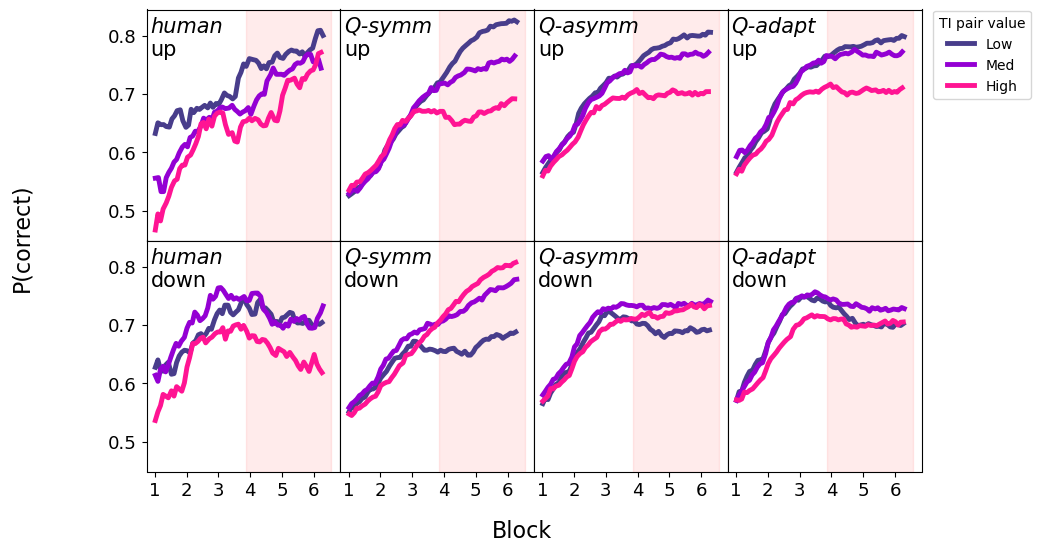

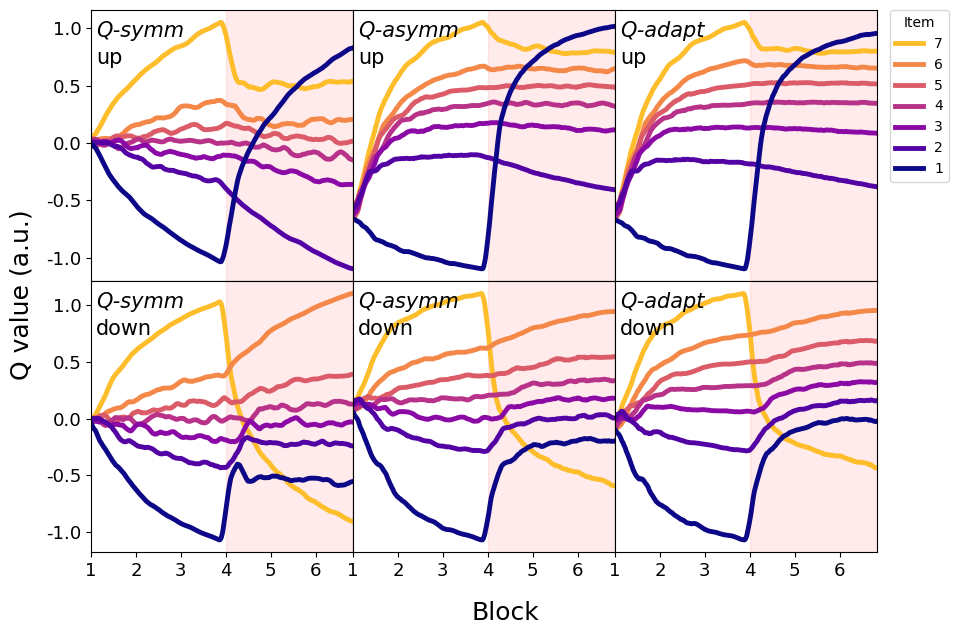

In [26]:
importlib.reload(plotter)
import plotter

## define subplots
subplot_splits = []
for d in ['up','down']:
    if fit_params == 'empirical':
        subplot_splits.append([d,'human'])
    for m in moi_names:
        subplot_splits.append([d, m])
n_rows = len(subplot_splits[0])
n_cols = int(len(subplot_splits)/2)
subplot_dims = [n_rows,n_cols]


## accuracy plots
extremes=False
value_split = 'lmh'
plot_split = False
bin_width = 100
step = 5
min_periods = 1
fig, axs = plotter.low_med_high(all_data.loc[all_data['Participant'].isin(sim_participants)], subplot_splits, subplot_dims,value_split, plot_split, bin_width, step, min_periods,extremes, 'Accuracy')

## Q val plots
Q_models = []
for m in subplot_splits:
    if m[1] != 'human':
        Q_models.append(m)
Q_dims = [len(Q_models[0]), int(len(Q_models)/2)]
figs_Q, axs = plotter.Q_plot(all_data.loc[all_data['Participant'].isin(sim_participants)], Q_models, Q_dims,10)

### Choice matrices

-0.5416267942583731 0.21411042661042665
-0.5082291955438686 0.10831074000539487
-0.5562409812409813 0.16562762634191208
-0.43085476567424047 0.06123178188938454


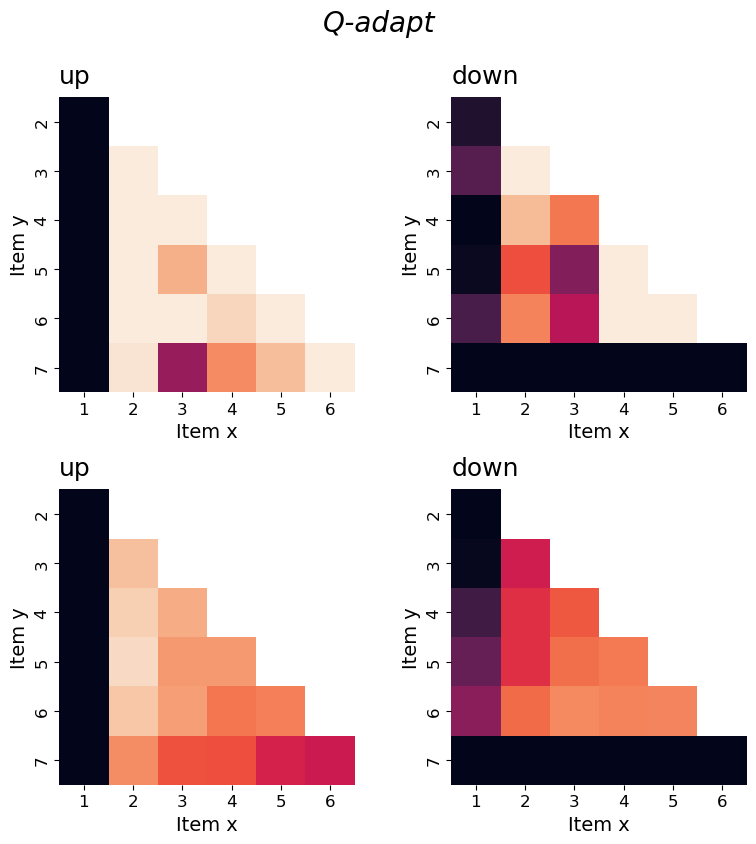

<Figure size 640x480 with 0 Axes>

In [34]:
## init
model = 'Q-adapt'
plot_setting = 3
if (plot_setting == 1) or (plot_setting == 2):
    vmin = 0.5
    vmax = 0.8
elif plot_setting == 3:
    vmin = -0.12
    vmax = 0.12

## plot for humans and then the model
# figs_human, figs2 = plotter.plot_cm(all_data, 'halfway', vmin, vmax, plot_setting, 'acc', 'human')
figs_Q3, figs2 = plotter.plot_cm(all_data, 'halfway', vmin, vmax, plot_setting, 'acc', model)

### Preference changes

Changes in selection of item 1 in post-switch relative to pre-switch
down:  0.09003126162472574 , SE =  0.022320691392799987 , t =  4.0335337306696175 , p =  0.00022104304620633027
up:  0.4619487070623964 , SE =  0.047330923758689684 , t =  9.759976572981744 , p =  6.677641610652419e-12

Changes in selection of item 7 in post-switch relative to pre-switch
down:  -0.40645613191656077 , SE =  0.03803031773378125 , t =  -10.687686985994265 , p =  1.1034586492230454e-13
up:  0.022902634442990195 , SE =  0.019157172128134205 , t =  1.1955122754968313 , p =  0.23929443603128836

ttest of moved item preference change (down-7 vs up-1): t =  0.9227612671995146 , p =  0.3588721746392902
ttest of unmoved item preference change (down-1 vs up-7): t =  -2.253128905143634 , p =  0.026954727500065775


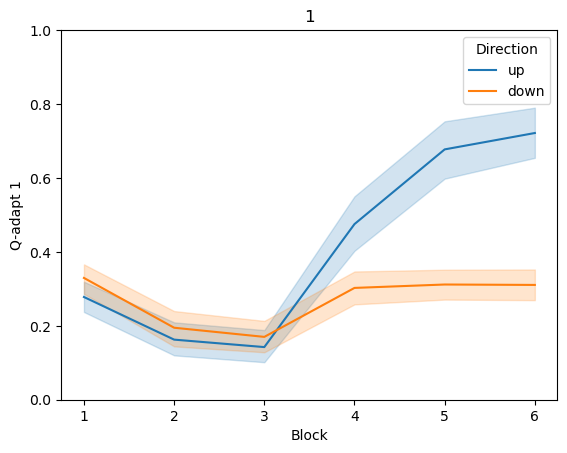

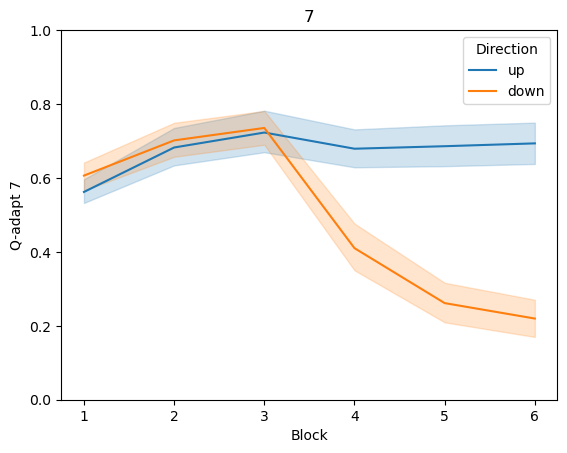

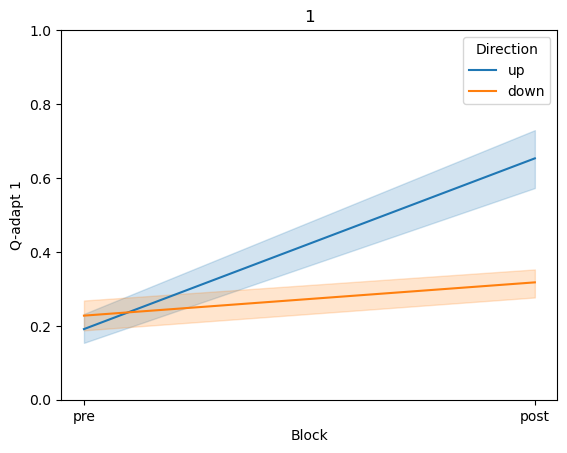

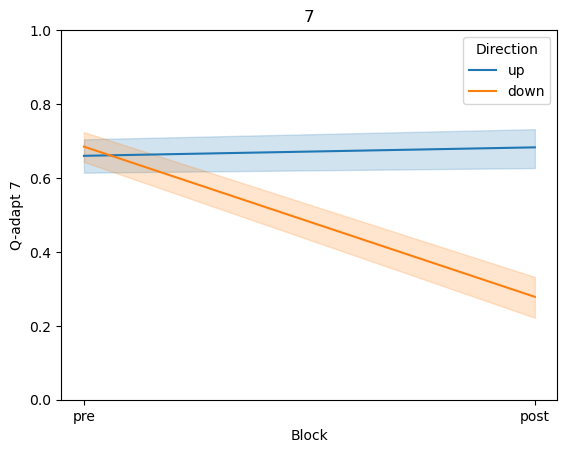

In [124]:
importlib.reload(plotter)
model = 'Q-adapt'
df_prefs = plotter.pref_change(all_data, model, plot = True)

### Plot all params


Q-symm
down a1 : mean =  0.0474781983509156
up a1 : mean =  0.03156910220237141
down eta : mean =  9.344868227210084
up eta : mean =  7.970758465429943
down tauI : mean =  0.08944513417465563
up tauI : mean =  0.06466831398637984

Q-asymm
down a1 : mean =  0.04305405269680425
up a1 : mean =  0.10535189812621684
down a2 : mean =  0.04715625973619614
up a2 : mean =  0.004048142488834561
significant difference
down eta : mean =  1.9209148807150331
up eta : mean =  1.0936551168641708
down tauI : mean =  0.2118637139715348
up tauI : mean =  0.2069670975020792

Q-adapt
down a0 : mean =  0.050802493666280146
up a0 : mean =  0.09303534475416575
down eta : mean =  2.133984863254888
up eta : mean =  2.4268956456013804
down tauI : mean =  0.19862510750679394
up tauI : mean =  0.21207159894316463
down meta : mean =  0.4029601568464618
up meta : mean =  0.2055008427533992


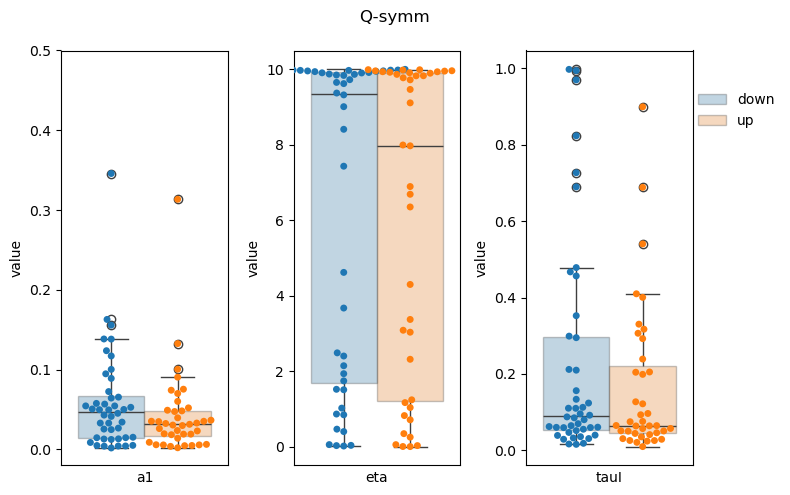

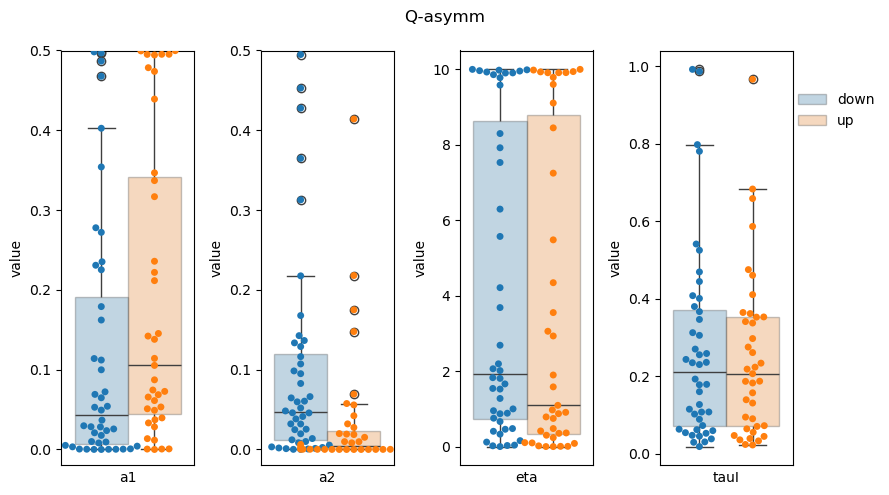

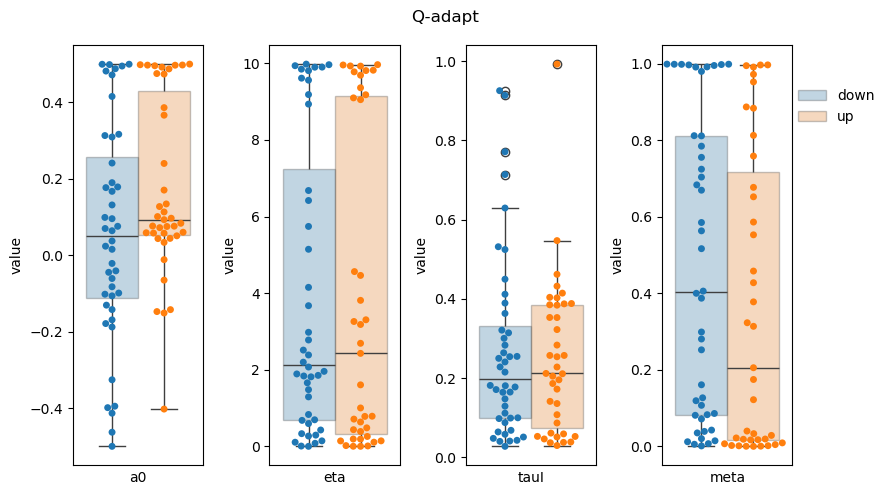

In [35]:
## format params for plotting
RL_params = {}
for model in [*df_fits][:]:
    params = model_params[model]
    RL_params[model] = df_fits[model][np.append(params, 'Direction')].melt(var_name = 'param', id_vars = 'Direction')

## boxplot params for each model of interest
for current_model in RL_params.keys():
    current_params = model_params[current_model]

    plotter.param_boxplot(df_fits, current_model, current_params)
    
    ## print means
    print(current_model)
    for param in current_params:
        for d in directions:
            print(d, param, ': mean = ',df_fits[current_model].loc[df_fits[current_model]['Direction']==d, param].median())
        t, p = stats.ttest_ind(df_fits[current_model].loc[df_fits[current_model]['Direction']=='up', param], df_fits[current_model].loc[df_fits[current_model]['Direction']=='down', param])
        if p<0.05:
            print('significant difference')

### Inspect asymmetry

#### Plot asymm index

mean asymm
up asymm =  0.3800741397813264 +/- 0.10910270051470591
down asymm =  0.3388701737560974 +/- 0.10763039029269338

wilcoxon of asymm against 0,  Q-asymm
down , p =  0.009559878856634896
up , p =  0.009475304279476404

mann-whitney comparing asymms in both groups
U =  876.0 P =  0.8731389889197789



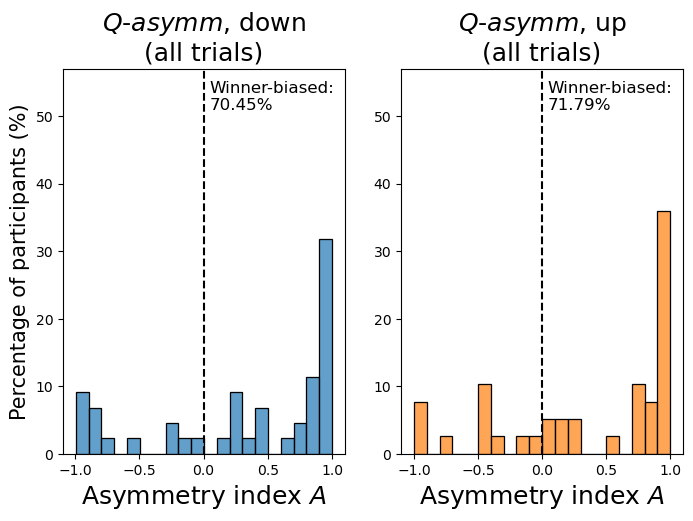

In [35]:
## select relevant model (Q-asymm or Q-asymm_m2, since these are the only models with an asymmetry index)
model = 'Q-asymm'
# model = 'Q-asymm_m2'
df_fits[model]['asymm'] = (df_fits[model]['a1'] - df_fits[model]['a2']) / np.abs(df_fits[model]['a1'] + df_fits[model]['a2'])
df_fits[model]['abs asymm'] = np.abs(df_fits[model]['asymm'])

## histograms per direction
figs_asymm, axs = plt.subplots(1,2, figsize = (8,5))
colours = sns.color_palette()
for di, d in enumerate(directions):
    ax = axs[di]
    sns.histplot(data = df_fits[model].loc[df_fits[model]['Direction']==d], x = 'asymm', ax = ax, color = colours[di], alpha = 0.7, binwidth =0.1
                    , stat = 'percent', palette = 'magma')
    ax.set_xlabel('Asymmetry index A', fontsize = 15)
    ax.set_xlabel(r'Asymmetry index $A$', fontsize = 18)
    ax.set_title(model+', '+d, fontsize = 18)
    ax.set_title(r'$\mathit{Q\text{-}asymm}$, '+d+'\n(all trials)', fontsize = 18)
    ax.set_ylim([0,57])
    ax.axvline(x=0, color = 'black', linestyle = '--')
    n_wb = len(df_fits[model].loc[(df_fits[model]['Direction']==d) & (df_fits[model]['asymm']>0)])
    n_lb = len(df_fits[model].loc[(df_fits[model]['Direction']==d) & (df_fits[model]['asymm']<0)])
    percentage = np.round(n_wb/(n_wb+n_lb)*100,2)
    ax.text(0.52, 0.97, 'Winner-biased:\n'+str(percentage)+'%', transform=ax.transAxes, fontsize=12, verticalalignment='top')
axs[0].set_ylabel('Percentage of participants (%)', fontsize = 15)
axs[1].set_ylabel('')

## wilcoxon test against 0
print('mean asymm')
print('up asymm = ', df_fits[model].loc[df_fits[model]['Direction']=='up', 'asymm'].mean(), '+/-', df_fits[model].loc[df_fits[model]['Direction']=='up', 'asymm'].sem())
print('down asymm = ', df_fits[model].loc[df_fits[model]['Direction']=='down', 'asymm'].mean(), '+/-', df_fits[model].loc[df_fits[model]['Direction']=='down', 'asymm'].sem())
print()
print('wilcoxon of asymm against 0, ',model)
for d in directions:
    sign = statsmodels.stats.descriptivestats.sign_test(df_fits[model].loc[df_fits[model]['Direction']==d, 'asymm'], mu0=0)
    print(d,', p = ', sign[1])
print()
    

## mann-whitney u test to compare asymmetry between directions
print('mann-whitney comparing asymms in both groups')
mann = stats.mannwhitneyu(df_fits[model].loc[df_fits[model]['Direction']=='up', 'asymm'], df_fits[model].loc[df_fits[model]['Direction']=='down', 'asymm'], method = 'auto')
print('U = ', mann.statistic, 'P = ', mann.pvalue)
print()


## analysis of pre and post asymmetries for Q-asymm^2
if (model == 'Q-asymm_m2'):

    ## calculate asymmetry indices pre vs post
    df_fits[model]['omi asymm'] = (df_fits[model]['omi1'] - df_fits[model]['omi2']) / np.abs(df_fits[model]['omi1'] + df_fits[model]['omi2'])
    df_fits[model]['asymm diff'] = df_fits[model]['omi asymm'] - df_fits[model]['asymm'] 
    df_fits[model]['a1 diff'] = df_fits[model]['omi1'] - df_fits[model]['a1'] 
    df_fits[model]['a2 diff'] = df_fits[model]['omi2'] - df_fits[model]['a2'] 


    ## print post-switch asymm index
    print('mean omi asymm')
    print('up omi asymm = ', df_fits[model].loc[df_fits[model]['Direction']=='up', 'omi asymm'].mean(), '+/-', df_fits[model].loc[df_fits[model]['Direction']=='up', 'omi asymm'].sem())
    print('down omi asymm = ', df_fits[model].loc[df_fits[model]['Direction']=='down', 'omi asymm'].mean(), '+/-', df_fits[model].loc[df_fits[model]['Direction']=='down', 'omi asymm'].sem())
    print()
    print('wilcoxon of asymm against 0, ',model)
    for d in directions:
        sign = statsmodels.stats.descriptivestats.sign_test(df_fits[model].loc[df_fits[model]['Direction']==d, 'omi asymm'], mu0=0)
        print(d,', p = ', sign[1])
    print()

    ## mann-whitney u test to compare asymmetry between directions
    print('mann-whitney comparing omi in both groups')
    mann = stats.mannwhitneyu(df_fits[model].loc[df_fits[model]['Direction']=='up', 'omi asymm'], df_fits[model].loc[df_fits[model]['Direction']=='down', 'omi asymm'], method = 'auto')
    print('U = ', mann.statistic, 'P = ', mann.pvalue)
    print()

    
    ## plots
    figs_asymm, axs = plt.subplots(1,2, figsize = (8,5))
    figs_asymm2, axs2 = plt.subplots(1,2, figsize = (8,5))
    for di, d in enumerate(directions):

        ## post-switch asymm
        ax = axs[di]
        sns.histplot(data = df_fits[model].loc[df_fits[model]['Direction']==d], x = 'omi asymm', ax=ax,color = colours[di], alpha = 0.7, binwidth =0.1
                    , stat = 'percent', palette = 'magma')
        ax.set_title(model+', '+d, fontsize = 18)
        ax.set_ylim([0,50])
        ax.set_xlabel('Omi Asymmetry', fontsize = 18)
        
        ## pre vs post asymm diff
        ax = axs2[di]
        sns.histplot(data = df_fits[model].loc[df_fits[model]['Direction']==d], x = 'asymm diff', ax=ax,color = colours[di], alpha = 0.7, binwidth =0.1
                    , stat = 'percent', palette = 'magma')
        ax.set_title(r'$\mathit{Q\text{-}asymm}^{2}$, '+d, fontsize = 18)
        ax.set_xlim([-2,2])
        ax.set_ylim([0,20])
        ax.set_xlabel(r'$\mathit{A_{post}-A_{pre}}$', fontsize = 18)

    axs[0].set_ylabel('Percentage of participants (%)', fontsize = 15)
    axs[1].set_ylabel('')
    axs2[0].set_ylabel('Percentage of participants (%)', fontsize = 15)
    axs2[1].set_ylabel('')


    ## check whether the change in asymm is related to how good the participant is at adapting to the changepoint
    print('asymm change x adaptability')
    figs3, axs3 = plt.subplots(1,2, figsize = (10,5))
    for d in directions:
        x = df_fits[model].loc[df_fits[model]['Direction']==d, 'asymm diff']
        y1 = df_acc_by_switch.loc[(df_acc_by_switch['Switched']=='post') & (df_acc_by_switch['Direction']==d), 'Accuracy human'].to_numpy()
        y2 = df_prefs.loc[(df_prefs['Block']=='post') & (df_prefs['Direction']==d), 'human moved anchor change pre vs post'].to_numpy()
        adapt_types = ['post TI accuracy', 'preference for moved anchor item']
        for yi, y in enumerate([y1, y2]):
            ax = axs3[yi]
            sns.regplot(x = x, y = y, label = d, ax = ax)
            corr = scipy.stats.pearsonr(x,y)
            print(d,', ',adapt_types[yi],', r = ', corr[0], 'p = ', corr[1])
            ax.set_xlabel(r'$\mathit{A_{post}-A_{pre}}$', fontsize = 18)
    axs3[0].legend(loc = 'lower left')
    axs3[1].legend(loc = 'lower right')
    print()


    print('wilcoxon of pre-post asymm indices') 
    for d in directions:
        asymm_tmp = df_fits[model].loc[df_fits[model]['Direction']==d,['asymm', 'omi asymm']].to_numpy()
        wilc = stats.wilcoxon(asymm_tmp[:,0], asymm_tmp[:,1], method = 'approx', alternative='two-sided')
        print(d, 'Z = ', wilc.zstatistic, 'P = ', wilc.pvalue)

    print()

    axs3[0].set_ylabel('Post-changepoint TI accuracy', fontsize = 15)
    axs3[1].set_ylabel('Pre- vs post-changepoint \npreference for moved anchor item', fontsize = 15)
    print()
    plt.subplots_adjust(wspace=0.5)

#### Model-agnostic vs -based biases

In [15]:
## establish which participants are winner-biased and loser-biased under the current model 
poi_idx = {}
# current_model = 'Q-asymm'
current_model = 'Q-adapt'
for di, d in enumerate(directions):

    ## i.e. participants who have a1>a2 or a2>a1
    if (current_model == 'Q-asymm'):
        asymm_ps[d][current_model+'-estimated wb'] = df_fits[current_model].loc[(df_fits[current_model]['Direction']==d) & (df_fits[current_model]['a1']>df_fits[current_model]['a2']), 'Participant'].to_numpy()
        asymm_ps[d][current_model+'-estimated lb'] = df_fits[current_model].loc[(df_fits[current_model]['Direction']==d) & (df_fits[current_model]['a1']<df_fits[current_model]['a2']), 'Participant'].to_numpy()
    
    ## i.e. participants who have a0>0 or a0<0
    elif (current_model == 'Q-adapt'):
        asymm_ps[d][current_model+'-estimated wb'] = df_fits[current_model].loc[(df_fits[current_model]['Direction']==d) & (df_fits[current_model]['a0']>=0), 'Participant'].to_numpy()
        asymm_ps[d][current_model+'-estimated lb'] = df_fits[current_model].loc[(df_fits[current_model]['Direction']==d) & (df_fits[current_model]['a0']<0), 'Participant'].to_numpy()
    print(d, 'n_comp: ',len(asymm_ps[d][current_model+'-estimated wb']), ', n_anti_comp: ',len(asymm_ps[d][current_model+'-estimated lb']))

    ## get participant indices
    poi_idx[d] = {}
    for bias in ['wb','lb']:
        poi_idx[d][bias] = []
        for p in asymm_ps[d][current_model+'-estimated '+bias]:
            poi_idx[d][bias].append(np.where(all_participants[di]==p)[0])
        poi_idx[d][bias] = np.array(poi_idx[d][bias])

## check to see if these participants match in the model-free and model-estimated cases
for d in directions:
    print(d)
    for bias in ['wb','lb']:
        mf = asymm_ps[d]['model-free '+bias]
        mb = asymm_ps[d][current_model+'-estimated '+bias]
        misclassified_ps = [mfp for mfp in mf if mfp not in mb]
        print(str(len(misclassified_ps))+' Ps classified as ',bias,' mf, but not by '+current_model+':',misclassified_ps)
    print()


### plot accuracy, split by winner- and loser-biased participants

## define subplots
subplot_splits = []
for d in ['up','down']:
    if fit_params == 'empirical':
        subplot_splits.append([d,'human'])
    for m in [current_model]:
        subplot_splits.append([d, m])
n_rows = len(subplot_splits[0])
n_cols = int(len(subplot_splits)/2)
subplot_dims = [n_rows,n_cols]
bin_width = 100
extremes = False
for bias in ['wb','lb']:

    ## subselect participants defined as biased by the model-agnostic method
    # data = all_data.loc[all_data['Participant'].isin(asymm_ps['down']['model-free '+bias]) | all_data['Participant'].isin(asymm_ps['up']['model-free '+bias])]

    ## or, subselect participants defined as biased by the model-based method
    data = all_data.loc[all_data['Participant'].isin(asymm_ps['down'][current_model + '-estimated '+bias]) | all_data['Participant'].isin(asymm_ps['up'][current_model + '-estimated '+bias])]
    data_ps = data['Participant'].unique()

    ## plot accuracy
    figs, axs = plotter.low_med_high(data, subplot_splits, subplot_dims,'lmh', plot_split, bin_width, step, min_periods, extremes, bias)

    ## Q val plots
    Q_models = []
    for m in subplot_splits:
        if m[1] != 'human':
            Q_models.append(m) 
    Q_dims = [len(Q_models[0]), int(len(Q_models)/2)]
    figs, axs = plotter.Q_plot(data, Q_models, Q_dims,30)


    ## choice matrices
    plot_setting = 3
    if (plot_setting == 1) or (plot_setting == 2):
        vmin = 0.5
        vmax = 0.75
    elif plot_setting == 3:
        vmin = -0.1
        vmax = 0.1
    data = all_data.loc[all_data['Participant'].isin(asymm_ps['down'][current_model + '-estimated '+bias]) | all_data['Participant'].isin(asymm_ps['up'][current_model + '-estimated '+bias])]
    data = all_data.loc[all_data['Participant'].isin(asymm_ps['down']['model-free '+bias]) | all_data['Participant'].isin(asymm_ps['up']['model-free '+bias])]
    figs, _ = plotter.plot_cm(data, 'halfway', vmin, vmax, plot_setting, 'acc', current_model)



NameError: name 'asymm_ps' is not defined

### Q-adapt illustration

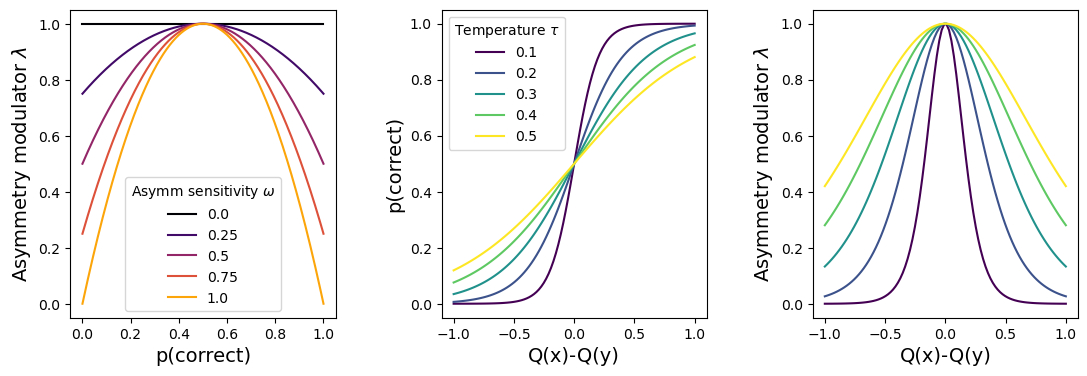

In [42]:
Q_diff = np.linspace(-1,1,100)
fig, axs = plt.subplots(1,3, figsize = (13,4))
x = np.linspace(0, 1, 1000)
n_omegas = 5
for oi, omega in enumerate(np.linspace(0,1,n_omegas)):
    axs[0].plot(x, RL.entropy_like(x, omega), label = omega, color = plt.cm.inferno(oi/(n_omegas)))
axs[0].set_xlabel('p(correct)', fontsize = 14)
axs[0].set_ylabel('Asymmetry modulator $\lambda$', fontsize = 14)
axs[0].legend(title=r'Asymm sensitivity $\omega$')
a0 = 0.1
n_tau = 5
for ti, tau in enumerate(np.linspace(0.1,0.5,n_tau)):
    tau = np.round(tau,2)
    CP = RL.sigmoid(Q_diff, tau)
    symm = RL.entropy_like(CP,1)
    axs[1].plot(Q_diff,CP, label = tau, color = plt.cm.viridis(ti/(n_tau-1)))
    axs[1].set_xlabel('Q(x)-Q(y)', fontsize = 14)
    axs[1].set_ylabel('p(correct)', fontsize = 14)
    axs[1].legend(title=r'Temperature $\tau$')
    axs[2].plot(Q_diff,symm, label = tau,color = plt.cm.viridis(ti/(n_tau-1)))
    axs[2].set_xlabel('Q(x)-Q(y)', fontsize = 14)
    axs[2].set_ylabel('Asymmetry modulator $\lambda$', fontsize = 14)
plt.subplots_adjust(wspace=0.4)

# Model/param recovery

## Model identification

### Load recovered fits

In [16]:
with open('recovery/10_runs_per_p_fits_final.pkl', 'rb') as f:
    df_recovery = pickle.load(f)

In [17]:
## some formatting
def extract_p(string):
    import re
    match = re.search(r'p(\d+)_sim', string)
    if match:
        return int(match.group(1))
    else:
        return None
rm_keys = []
for gen in df_recovery.keys():
    if len(df_recovery[gen].keys()) == 0:
        rm_keys.append(gen)
        continue
    for fitted in df_recovery[gen].keys():
        df_recovery[gen][fitted]['Simulation run'] = df_recovery[gen][fitted]['Participant'].to_numpy()
        df_recovery[gen][fitted]['Participant'] = df_recovery[gen][fitted]['Participant'].apply(extract_p)
        df_recovery[gen][fitted] = df_recovery[gen][fitted].sort_values('Participant')
    
        ## remove participants not in current set?
        df_recovery[gen][fitted] = df_recovery[gen][fitted].loc[df_recovery[gen][fitted]['Participant'].isin(participants)]
        
for rm in rm_keys:
    df_recovery.pop(rm)

## add the AICs in
for gen_model in df_recovery.keys():
    for fitted_model in df_recovery[gen_model].keys():
        n_params = len(model_params[fitted_model])
        df_recovery[gen_model][fitted_model]['AIC'] = 2*n_params + df_recovery[gen_model][fitted_model]['loss']
        df_recovery[gen_model][fitted_model]['BIC'] = n_params*np.log(df_recovery[gen_model][fitted_model]['n_trials']) + df_recovery[gen_model][fitted_model]['loss']


print()
n_simulations = len(df_recovery['Q-asymm']['Q-asymm'])

### Confusion matrix

gen_model,Q-symm,Q-asymm,Q-adapt
best,,,
Q-symm,0.793182,0.161364,0.052273
Q-asymm,0.118182,0.518182,0.243182
Q-adapt,0.088636,0.320455,0.704545


gen_model,Q-symm,Q-asymm,Q-adapt
best,,,
Q-symm,0.843590,0.089744,0.015385
Q-asymm,0.128205,0.525641,0.317949
Q-adapt,0.028205,0.384615,0.666667


gen_model,Q-symm,Q-asymm,Q-adapt
best,,,
Q-symm,0.787810,0.160271,0.051919
Q-asymm,0.134367,0.589147,0.276486
Q-adapt,0.079592,0.287755,0.632653


gen_model,Q-symm,Q-asymm,Q-adapt
best,,,
Q-symm,0.889189,0.094595,0.016216
Q-asymm,0.131926,0.540897,0.327177
Q-adapt,0.026128,0.356295,0.617577


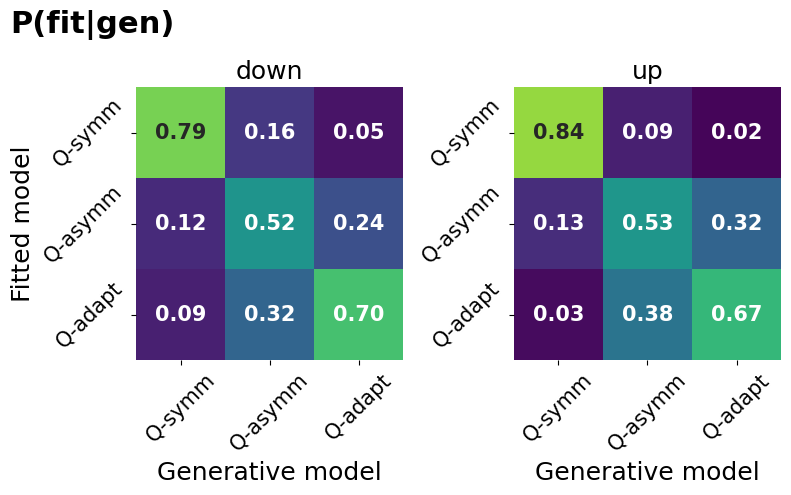

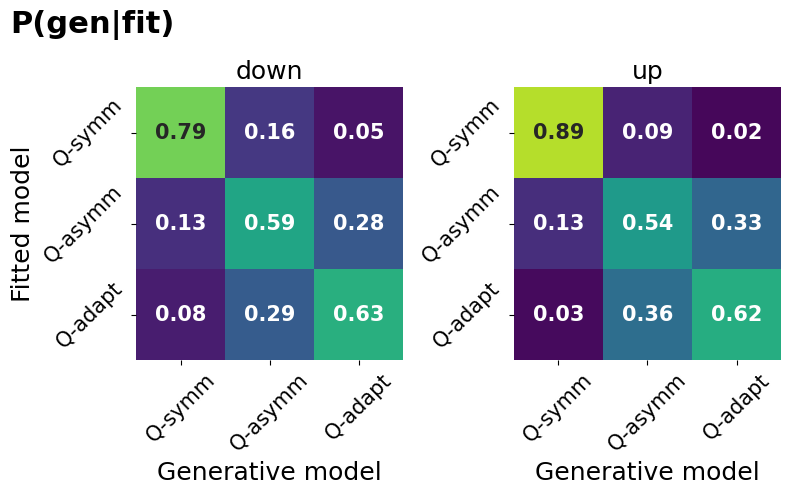

In [18]:
## choose evidence metric
evidence = 'AIC'
# evidence = 'BIC'
moi = [key for key in df_recovery.keys()]
n_moi = len(moi)

## init df 
model_rec = pd.DataFrame()
model_rec['gen_model'] = np.repeat(moi, n_simulations)
model_rec['Simulation run'] = np.zeros(n_simulations*n_moi)
# model_rec['Participant'] = np.zeros(n_simulations*n_moi)
# model_rec['Participant'] = np.tile(fit_participants, n_moi)

## get the best-fitting model for each simulated dataset (i.e. each generative model)
for gen_model in df_recovery.keys():
    for fitted_model in df_recovery[gen_model].keys():
        df_recovery[gen_model][fitted_model] = df_recovery[gen_model][fitted_model].sort_values('Simulation run')
        model_rec.loc[model_rec['gen_model']==gen_model, 'Participant'] = df_recovery[gen_model][fitted_model]['Participant'].to_numpy()
        model_rec.loc[model_rec['gen_model']==gen_model, 'Simulation run'] = df_recovery[gen_model][fitted_model]['Simulation run'].to_numpy()
        model_rec.loc[model_rec['gen_model']==gen_model, fitted_model] = df_recovery[gen_model][fitted_model][evidence].to_numpy()
    model_rec['best'] = model_rec[moi].idxmin(axis=1)
model_rec['Direction'] = 'down'
model_rec.loc[model_rec['Participant']%2==0, 'Direction'] = 'up'


## confusion matrix
figs_conf, axs = plt.subplots(1,2, figsize = (8,5))
for di, d in enumerate(directions):

    ## get p(fit|gen) over the entire simulation set
    data = model_rec.loc[model_rec['Direction']==d]
    data = data.groupby(['best','gen_model']).size().unstack()/data['Simulation run'].nunique()

    
    ## reformat
    data = data[moi]
    data = data.reindex(moi)
    display(data)
    vmax = 1
    vmin = 0

    ## plot
    sns.heatmap(data, annot=True, ax = axs[di], cmap='viridis', cbar = False, vmax = vmax, vmin = vmin,fmt='.2f',
                annot_kws={"size": 15, "weight": "bold",  }
    )
    axs[di].set_title(d, fontsize = 18)
    axs[di].set_xlabel('Generative model', fontsize = 18)
    axs[di].set_xticklabels(axs[di].get_xticklabels(), rotation=45, fontsize = 12)
    axs[di].set_yticklabels(axs[di].get_yticklabels(), rotation=45, fontsize = 12)
    axs[di].tick_params(axis='both', which='major', labelsize=15)
axs[0].set_ylabel('Fitted model', fontsize = 18)
axs[1].set_ylabel('')
figs_conf.suptitle('P(fit|gen)', fontsize = 22, weight = 'bold', x=0.12)
plt.tight_layout()

## inverted confusion matrix
figs_inv, axs = plt.subplots(1,2, figsize = (8,5))
for di, d in enumerate(directions):
    data = model_rec.loc[model_rec['Direction']==d]
    data = data.groupby(['best','gen_model']).size().unstack()/data['Simulation run'].nunique()
    data = data.div(data.sum(1),axis = 'rows')

    ## reformat
    data = data[moi]
    data = data.reindex(moi)
    display(data)

    ## plot
    sns.heatmap(data, annot=True, ax = axs[di], cmap='viridis', cbar = False,vmax = vmax, vmin = vmin,fmt='.2f',
                annot_kws={"size": 15, "weight": "bold", }
    )
    axs[di].set_title(d, fontsize = 18)
    axs[di].set_xlabel('Generative model', fontsize = 18)
    axs[di].set_xticklabels(axs[di].get_xticklabels(), rotation=45, fontsize = 12)
    axs[di].set_yticklabels(axs[di].get_yticklabels(), rotation=45, fontsize = 12)
    axs[di].tick_params(axis='both', which='major', labelsize=15)
axs[0].set_ylabel('Fitted model', fontsize = 18)
axs[1].set_ylabel('')
figs_inv.suptitle('P(gen|fit)', fontsize = 22, weight = 'bold', x=0.12, )
plt.tight_layout()

## Param recovery

##### Generate trials

In [23]:
### generate dataset under model of interest

## initialise the whole gamut of dataframes for the recovery
df_param = {}
fitting_param = {}
gen_trials= {}
tmp = {}
moi = ['Q-asymm','Q-adapt']
n_moi = len(moi)
parallel = 1
fit_participants = participants
n_fit_participants = len(fit_participants)
for gen_m_s in range(1):
    for gen_m in [1,2]:
        gen_model = all_models[gen_m_s][gen_m] ## unlike in the model recovery, the generative model is also the fitted model
        fitting_param[gen_model] = {}
        gen_trials[gen_model] = pd.DataFrame()
        current_params = model_params[gen_model]
        df_param[gen_model] = pd.DataFrame()
        fitting_param[gen_model] = {
            'Participant': [],
            'Simulated Participant': [],
            'Sim_ID': [],
            'Direction': [],
            'loss': [],
            'n_trials': [],
            'nfev': [],
            'nit': [],
        }
        for param in current_params:
            fitting_param[gen_model][param] = []
            fitting_param[gen_model][param+'_0'] = []
            fitting_param[gen_model]['gen_'+param] = []

## define param bounds
n_steps = 10
base = np.finfo(float).tiny
param_iters = {
    'Q-asymm':{
        'a1': np.linspace(base,0.5, n_steps),
        'a2': np.linspace(base,0.5, n_steps),
        'eta': np.linspace(base,10, n_steps),
        'tauI': np.linspace(base,1, n_steps)
    },
    # 'Q-adapt':{
    #     'a0': np.linspace(-0.5,0.5, n_steps),
    #     'eta': np.linspace(base,10, n_steps),
    #     'tauI': np.linspace(base,1, n_steps)
    # },
    'Q-adapt':{
        'a0': np.linspace(-0.5,0.5, n_steps),
        'eta': np.linspace(base,10, n_steps),
        'tauI': np.linspace(base,1, n_steps),
        'meta': np.linspace(base,1, n_steps)
    }
}

In [24]:
## load and clean
with open('recovery/param_recovery_fits_final.pkl', 'rb') as f:
    df_param = pickle.load(f)
for key in df_param.keys():
    current_params = model_params[key]
    for param in current_params:
        df_param[key]['gen_'+param] = df_param[key]['gen_'+param].apply(lambda x: x[0])

Q-asymm
a1
down , r =  0.765512379631613 , p =  6.56551366472349e-86
up , r =  0.7501965130470829 , p =  1.0572038592691283e-71
a2
down , r =  0.7615142487546802 , p =  1.6289497841058853e-84
up , r =  0.7920215067690903 , p =  3.564572001115167e-85
eta
down , r =  0.6548531118750514 , p =  3.1238760792555472e-55
up , r =  0.6615545644269066 , p =  1.9314951004589044e-50
tauI
down , r =  0.7353702517423153 , p =  4.993012771060826e-76
up , r =  0.7377359232160393 , p =  3.39310855455267e-68

Q-adapt
a0
down , r =  0.864192736063913 , p =  9.809235961652976e-133
up , r =  0.8986866838899715 , p =  5.924057311579993e-141
eta
down , r =  0.7021058752713565 , p =  1.3777375276662775e-66
up , r =  0.7123258466508294 , p =  1.247437611545804e-61
tauI
down , r =  0.711129960038758 , p =  5.138903673153084e-69
up , r =  0.7263589001784387 , p =  3.6451066509718053e-65
meta
down , r =  0.5710319139149913 , p =  1.9402871971452233e-39
up , r =  0.4967065340756304 , p =  1.090560897571313e-25



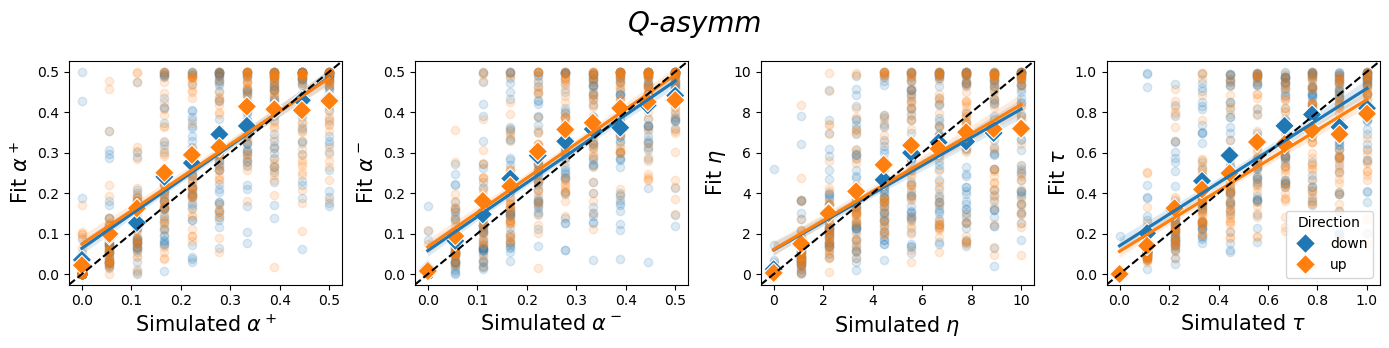

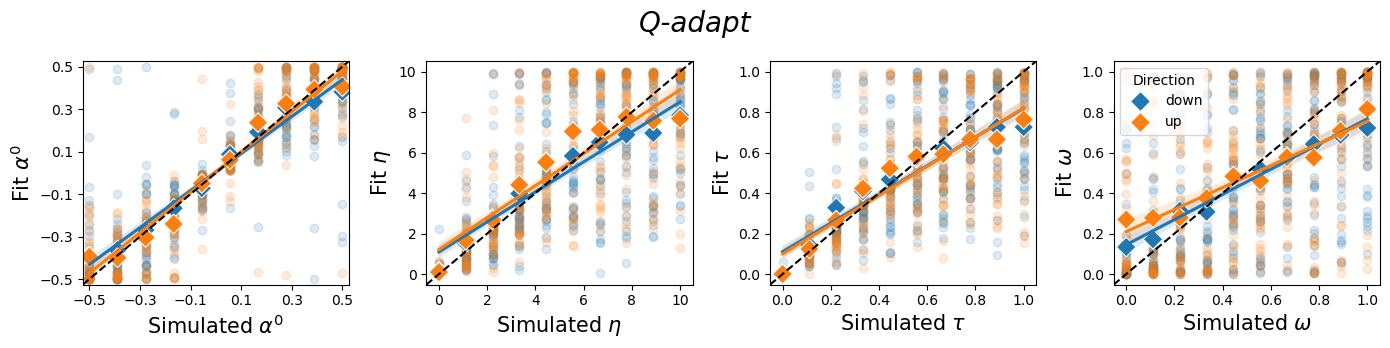

In [25]:
## plot correlations
param_legends = {
    'a1': r'$\alpha^+$',
    'a2': r'$\alpha^-$',
    'a0': r'$\alpha^0$',
    'eta': r'$\eta$',
    'tauI': r'$\tau$',
    'meta': r'$\omega$',
}
param_corrs = {}
fit_param_corrs = {}
for model in ['Q-asymm', 'Q-adapt']:
    n_params = len(model_params[model])
    figs, axs = plt.subplots(1,n_params, figsize = (n_params*3.5,3.5))
    print(model)
    param_corrs[model] = {}
    fit_param_corrs[model] = {}
    for d in directions:
        param_corrs[model][d] = pd.DataFrame(columns = ['Sim '+param for param in model_params[model]], index = model_params[model])
        fit_param_corrs[model][d] = pd.DataFrame(columns = model_params[model], index = model_params[model])
        
    for pi, param in enumerate(model_params[model]):
        print(param)
        ax = axs[pi]
        for d in directions:

            ## subselect relevant fits
            current_iters = param_iters[model][param]
            data = df_param[model].loc[(df_param[model]['Direction']==d) 
                                       & (df_param[model]['gen_'+param].isin(current_iters))
                                       ]
            data = data.dropna(subset = [param, 'gen_'+param])
            corr = scipy.stats.pearsonr(data['gen_'+param], data[param])
            print(d, ', r = ', corr[0], ', p = ', corr[1])

            ## plot
            sns.regplot(data = data, y = param, x = 'gen_'+param, ax = ax,scatter_kws={'alpha':0.15})
            ax.set_xlabel('Simulated '+param_legends[param], fontsize = 15)
            ax.set_ylabel('Fit '+param_legends[param], fontsize = 15)
            xlims = [current_iters[0] - ax.get_xlim()[1]*0.05, current_iters[-1] + ax.get_xlim()[1]*0.05]
            ylims = [current_iters[0] - ax.get_ylim()[1]*0.05, current_iters[-1] + ax.get_ylim()[1]*0.05]
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)
            ax.set_xticks(np.linspace(current_iters[0],current_iters[-1], 6))
            ax.set_yticks(np.linspace(current_iters[0],current_iters[-1], 6))

            ## calculate correlation between gen param and every other sim param
            for param2 in model_params[model]:
                data2 = df_param[model].loc[(df_param[model]['Direction']==d) 
                                            & (df_param[model]['gen_'+param].isin(current_iters))
                                            ]
                data2 = data2.dropna(subset = [param2, 'gen_'+param2])
                corr = scipy.stats.pearsonr(data2['gen_'+param], data2[param2])
                param_corrs[model][d].loc[param2, 'Sim '+param] = corr[0]


                ## alternatively, calculate the correlation among recovered params (á la Daw)
                if param2 != param:
                    data2 = df_param[model].loc[(df_param[model]['Direction']==d) 
                                                # & (df_param[model]['gen_'+param].isin(current_iters))
                                                ]
                    corr = scipy.stats.pearsonr(data2[param], data2[param2])
                    fit_param_corrs[model][d].loc[param2, param] = corr[0]


        ## also plot the mean recovered param for each generative iteration
        if pi == n_params-1:
            legend=True
        else:
            legend=False
        data_mean = df_param[model].loc[(df_param[model]['gen_'+param].isin(current_iters))].groupby(['gen_'+param, 'Direction'])[param].mean().reset_index()
        sns.scatterplot(data = data_mean, x = 'gen_'+param, y = data_mean[param], ax = ax, hue = 'Direction', marker = 'D', s = 100, legend=legend)

        ## plot identity
        ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    plt.suptitle(model, fontsize = 20, fontstyle = 'italic')
    
    ## spacing
    plt.tight_layout()
    print()

    ## save
    # plotter.save_fig(figs, 'param_rec_'+model)
    

Sim a1      0.765512
Sim a2      0.761514
Sim eta     0.654853
Sim tauI    0.735370
dtype: float64 Sim a1     -0.155380
Sim a2     -0.105495
Sim eta     0.089057
Sim tauI   -0.103501
dtype: float64
Sim a1      0.750197
Sim a2      0.792022
Sim eta     0.661555
Sim tauI    0.737736
dtype: float64 Sim a1     -0.293504
Sim a2     -0.105692
Sim eta     0.077957
Sim tauI   -0.187441
dtype: float64
Sim a0      0.864193
Sim eta     0.702106
Sim tauI    0.711130
Sim meta    0.571032
dtype: float64 Sim a0     -0.021516
Sim eta    -0.014499
Sim tauI   -0.128481
Sim meta   -0.027356
dtype: float64
Sim a0      0.898687
Sim eta     0.712326
Sim tauI    0.726359
Sim meta    0.496707
dtype: float64 Sim a0      0.001697
Sim eta    -0.001385
Sim tauI   -0.127490
Sim meta   -0.064106
dtype: float64
a1      0.052157
a2      0.066603
eta    -0.045343
tauI    0.066603
dtype: float64 a1     -0.220061
a2     -0.220061
eta    -0.149831
tauI   -0.045343
dtype: float64
a1      0.037357
a2     -0.011953
eta    -

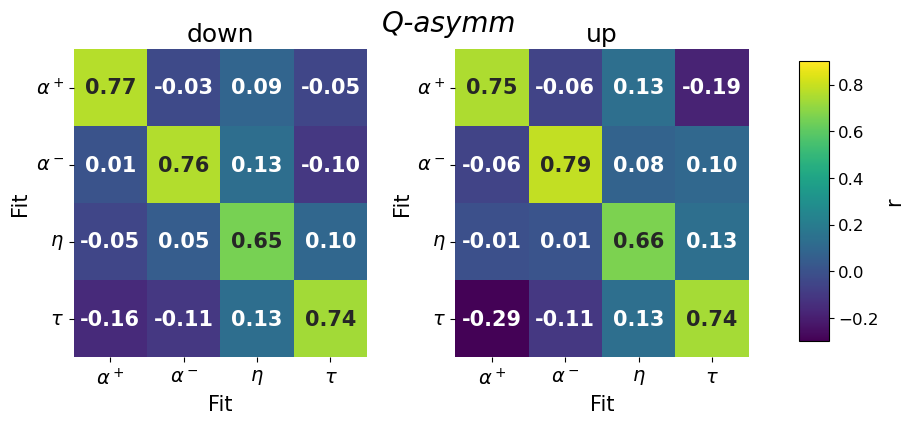

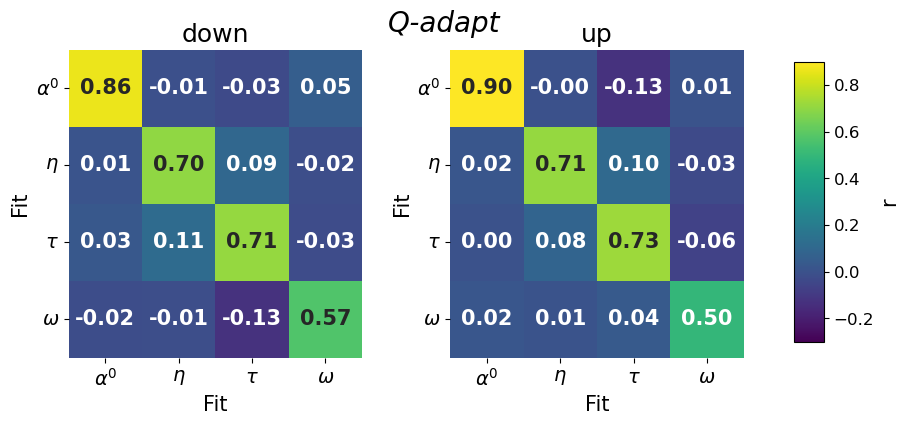

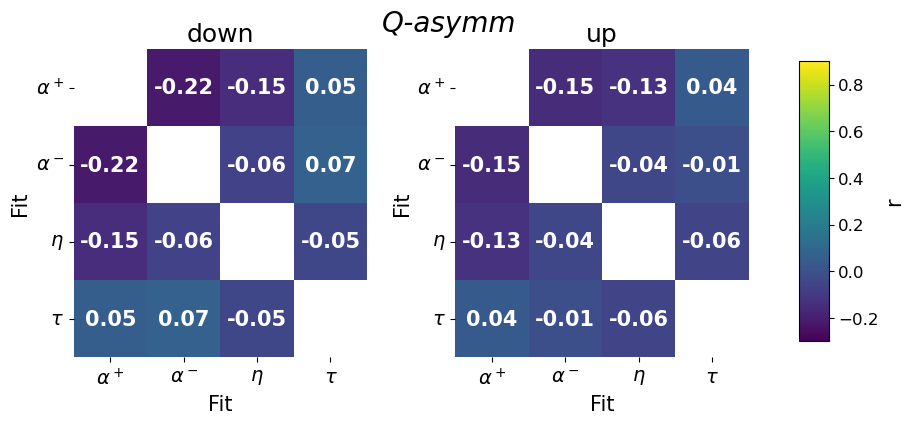

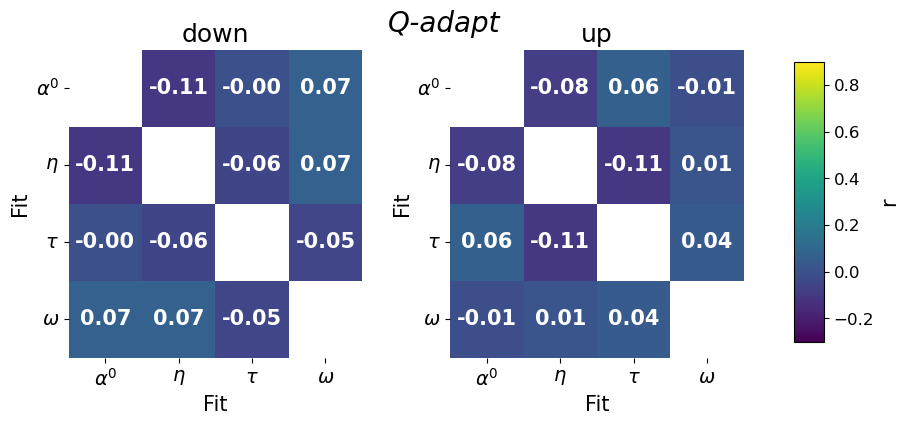

In [26]:
## plot sim x fit param corrs and then fit x fit param corrs heatmap
for ci, corrs in enumerate([param_corrs, fit_param_corrs]):
    for model in corrs.keys():
        fig, axs = plt.subplots(1,2, figsize = (10,4))
        for di, d in enumerate(directions):
            ax = axs[di]
            data = corrs[model][d].astype(float)
            labels = [param_legends[param] for param in data.index]
            print(np.max(data), np.min(data))
            vmin = -0.3
            vmax = 0.9
            sns.heatmap(data, annot=True, ax = ax, cmap='viridis', cbar = False, vmin = vmin, vmax = vmax,fmt='.2f',
                        annot_kws={"size": 15, "weight": "bold",}
            )
            ax.set_xticklabels(labels, rotation=0, fontsize = 14)
            ax.set_yticklabels(labels, rotation=0, fontsize = 14)
            ax.set_xlabel('Fit', fontsize = 15)
            # ax.set_xlabel('Sim', fontsize = 15)
            ax.set_ylabel('Fit', fontsize = 15)
            ax.set_title(d, fontsize = 18)
            plt.subplots_adjust(wspace = 0.3)
        plt.suptitle(model, fontsize = 20, fontstyle = 'italic')

        ## create new cbar
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
        cbar = fig.colorbar(ax.collections[0], cax=cbar_ax)
        cbar.set_label('r', fontsize = 15)
        cbar.ax.tick_params(labelsize=12)
        # plotter.save_fig(fig, 'param_corrs_'+model)
